# Modélisation d'un flot de voitures

## 1. Introduction





Nous allons développer ici la résolution numérique d'un problème de convection dans le cas d'un flot de voitures. Plus exactement, nous nous intéressons à la dissipation d'un embouteillage representée dans certaines conditions initiales par une densité plus élevée de voitures ( $\rho $ ). L'équation que nous utilisons pour analyser ce problème est comme suit:

\begin{equation}
\frac{\partial \rho}{\partial t}+\frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial x}=0
\end{equation}
Après quelques simplifications nous pouvons la réécrire en une forme plus facile à résoudre.

\begin{equation}
\frac{\partial \rho}{\partial t}+\frac{\partial F}{\partial x}=0
\end{equation}

On peut ensuite établir le lien entre $ \rho $ et F par les formule suivantes:


\begin{equation}
V=V_{max}(1-\frac{\rho}{\rho_{max}})
\end{equation}

\begin{equation}
F=V\rho
\end{equation}

\begin{equation}
F=F(\rho)=V(\rho)\rho=V_{max}\rho(1-\frac{\rho}{\rho_{max}})
\end{equation}


Pour résoudre numériquement nous devons choisir une discrétisation. Il nous est imposé d'utiliser un chemin précis pour le calcul : progressif dans le temps et rétrograde dans l'espace. Nous obtenons alors une équation de la forme :
\begin{equation}
\frac{u^{n+1}_i - u^n_i}{\Delta t} + \frac{v^n_{i} - v^n_{i-1}}{\Delta x}  = 0
\end{equation}

Nous avons un choix ici, nous pouvons développer notre équation de deux manières :
\begin{equation}
\frac{\rho^{n+1}_i - \rho^n_i}{\Delta t}- \frac{V_{max}}{\rho_{max}} (1-2\frac{\rho^n_{i}}{\rho_{max}}) \frac{\rho^n_{i}-\rho^n_{i-1}}{\Delta x}=0
\\
\frac{\rho^{n+1}_i - \rho^n_i}{\Delta t} + V_{max} \frac{\rho^n_{i} (1-\frac{\rho^n_{i}}{\rho_{max}})-\rho^n_{i-1} (1-\frac{\rho^n_{i-1}}{\rho_{max}})}{\Delta x} =0
\end{equation}

Intégrons les différentes discrétisations de $ \frac{\partial F}{\partial x} $ :

\begin{align}
\int_{x_0}^{x_{max}} \frac{\partial F}{\partial x} d x &\approx \sum_{i=1}^{N} V_{max}\left(1-\frac{2 \rho_i^n}{\rho_{max}}\right)\frac{\rho_i^n-\rho_{i-1}^n}{\Delta x} \Delta x\\
                                                        &= V_{max} (\rho_N - \rho_0) - \frac{2 V_{max}}{\rho_{max}}[\rho_1(\rho_1-\rho_0)+\rho_2(\rho_2-\rho_1)+ ... + \rho_N(\rho_N - \rho_{N-1})] \\
                                                        &\ne F(\rho(x_{max}) - F(\rho(x_0))
                                                        \\
\int_{x_0}^{x_{max}} \frac{\partial F}{\partial x} d x &\approx \sum_{i=1}^{N} V_{max}\left[\left(1-\frac{\rho_i^n}{\rho_{max}}\right)\rho_i^n - \left(1-\frac{\rho_{i-1}^n}{\rho_{max}}\right)\rho_{i-1}^n\right]\frac{\Delta x}{\Delta x}\\
                                                        &= V_{max}\left(\rho_N-\frac{\rho_N^2}{\rho_{max}}\right)-V_{max}\left(\rho_0-\frac{\rho_0^2}{\rho_{max}}\right)\\
                                                        &=F(\rho(x_{max})-F(\rho(x_0))
\end{align}

On voit alors que la deuxième est une meilleur aproximation car elle conserve le flot de voitures alors que la première, malgré le fait qu'analytiquement elle soit correcte, après intégration, sommation discrète, ne conserve pas le flot de voitures. 
En effet on doit avoir conservation du nombre de voiture. Autrement dit la denstité de voiture $\rho $ obéit a une équation de continuité. Ainsi la dérivée du nombre de voiture par rapport au temps doit être égale à la différence du flux entrant et sortant de la section de route :

\begin{equation}
\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x}=0 
\Delta \rho = F_{entrant} - F_{sortant} 
\end{equation}


Cela a pour conséquence que l'intégrale sur x de l'équation de continuité ne depend pa de la discrétisation sur x n'influence pas sur la valeur de l'intégrale finale. Cela peut changer localement mais globalement cela reste F(entrant)-F(sortant). En d'autres termes, l'algorithme conserve numériquement la réponse. Ainsi les seuls erreurs que nous allons commettre dans notre résolution vient des erreurs d'apporoximation dû au stockage des données sur un nombre fini d'octets (on a un volume de stockage limité) et non pas sur le pas de discrétisation selon la dimension spatiale. On voit bien que par la deuxième série de calcul nous mène à :

\begin{equation}
\int_{x_0}^{x_{max}} \frac{\partial F}{\partial x} d x = F(\rho(x_{max})-F(\rho(x_0))   
\end{equation}

Cela démontre bien ce que nous affirmons précedement : l'intégrale ne dépend pas du pas de discrétisation mais uniquement du flux entrant et sortant ce qui satisfait bien à l'équation de continuité.

## 2. Résolution 

Nous allons décrire dans cette partie la manière que nous avons utilisée pour résoudre ce problème. 

Tout d'abord nous importons les librairies nécessaires à la résolution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Les conditions qu'ils nous sont imposées sont la longueur de notre domaine (_L_), le nombre de pas pour la variable spatiale (_nx_) ainsi que la taille du pas de temps.

In [2]:
L = 11 # km
Dt = 0.001 # h
nx = 51

Dans un souci d'efficacité, nous avons fait une fonction qui calcule la solution. Nous pouvons la réutiliser facilement vu que certains paramètres changent dans cet exercice. 

In [3]:
def Traffic(rhocrete,rhoinit,Vmax,tmax):
    rhomax = 250
    dx = L/(nx-1)                     # calcul du pas selon la dimension spatiale
    nt = int(tmax/60/Dt)+1
    rho0 = np.ones(nx)*rhoinit        # creation de la condition initiale en rho
    rho0[10:20] = rhocrete
    rho = np.zeros((nt,nx))
    rho[0]=rho0
    v = np.zeros((nt,nx))
    v[0]= Vmax*(1-rho[0][:]/rhomax)   #calcul de v en 0
    vm = np.zeros(nt)#creation d'un vecteur qui contiendra les vitesses moyennes en chaque temps. 
    vm[0] = np.average(v[0])
    for n in range(1, nt):
        rho[n][1:] = rho[n-1][1:]-Vmax*\
        (rho[n-1][1:]*(1-rho[n-1][1:]/rhomax)-(rho[n-1][0:-1])*(1-rho[n-1][0:-1]/rhomax))*Dt/dx # calcul de la densite 
        rho[n][0] = rhoinit
        v[n][:] = Vmax*(1-rho[n][:]/rhomax)  #calcul de la vitesse
        vm[n]= np.average(v[n])              #calcul de la vitesse moyenne
        
    return v,rho,vm

On remaque que nous avons utilisé un tableau à double entrée pour $\rho $ et $v$ , qui reprend pour chaque ligne les différentes valeurs en chaque instant $t$. Cette structure de données a l'avantage d'être directement utilisable pour faire une animation.

Une autre astuce est la forme que nous avons utilisé pour calculer $\rho $  et $v$. L'utilisation d'une structure du type _rho[a:-b]_ permet de faire une boucle for en diminuant le temps de calcul.


## 3. Résultats et interprétations


L'exercice consistait à résoudre le problème de flot de voitures dans deux cas :
* Celui où $V_{max} = 80 $ km/h, $\rho_{init} = 10$ voitures/h, $\rho_{crete} = 50$ voitures/h.
* Celui où $V_{max} = 136 $ km/h, $\rho_{init} = 20$ voitures/h, $\rho_{crete} = 50$ voitures/h.

Grâce à notre fonction décrite ci-dessus, nous pouvons en sortir les solutions en l'appelant. En voici les réponses :


In [4]:
v1,rho1,vm1 = Traffic(50,10,80,6)
print("Pour une vitesse de 80 km/h")
print("La vitesse minimale à t= 0 minutes est {:.2f} km/h".format(min(v1[0])),\
     "ou, {:.2f} m/s".format(min(v1[0])/3.6))
print("La vitesse moyenne à t= 3 minutes est {:.2f} km/h".format(vm1[50]),\
     "ou, {:.2f} m/s".format(vm1[50]/3.6))
print("La vitesse minimale à t= 6 minutes est {:.2f} km/h".format(min(v1[100]),\
     "ou, {:.2f} m/s".format(min(v1[100])/3.6)))

v2,rho2,vm2 = Traffic(50,20,136,6)
print("Pour une vitesse de 136 km/h")
print("La vitesse minimale à t= 0 minutes est {:.2f} km/h".format(min(v2[0])),\
     "ou  {:.2f} m/s".format(min(v2[0])/3.6))
print("La vitesse moyenne à t= 3 minutes est {:.2f} km/h".format(vm2[50]),\
     "ou, {:.2f} m/s".format(vm2[50]/3.6))
print("La vitesse minimale à t= 3 minutes est {:.2f} km/h".format(min(v2[50])),\
     "ou {:.2f} m/s".format(min(v2[50])/3.6))

Pour une vitesse de 80 km/h
La vitesse minimale à t= 0 minutes est 64.00 km/h ou, 17.78 m/s
La vitesse moyenne à t= 3 minutes est 74.29 km/h ou, 20.64 m/s
La vitesse minimale à t= 6 minutes est 67.62 km/h
Pour une vitesse de 136 km/h
La vitesse minimale à t= 0 minutes est 108.80 km/h ou  30.22 m/s
La vitesse moyenne à t= 3 minutes est 121.94 km/h ou, 33.87 m/s
La vitesse minimale à t= 3 minutes est 111.55 km/h ou 30.99 m/s


Pour plus de compréhensions et d'analyse, nous pouvons nous concentrer sur l'étude des différents graphiques.


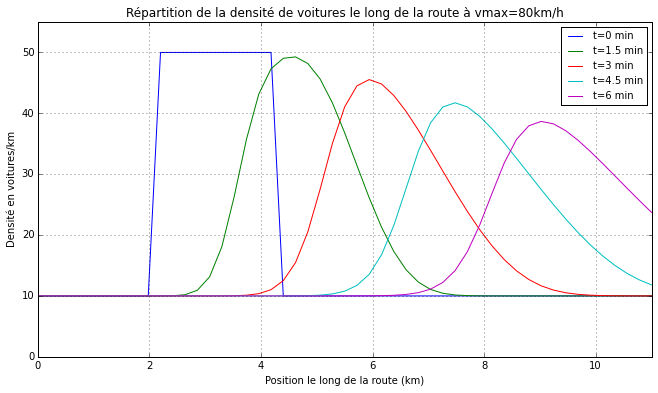

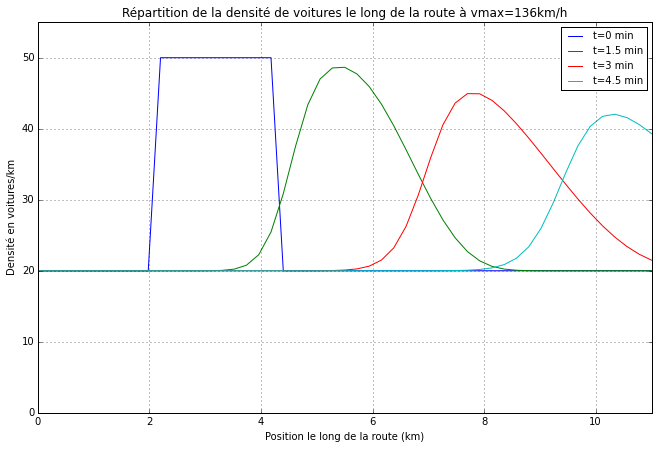

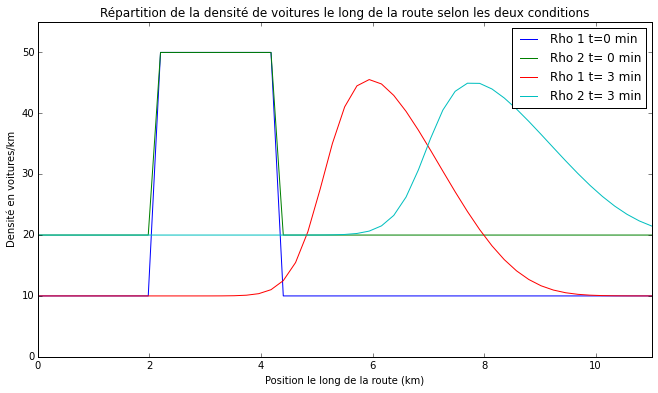

In [5]:
x = np.linspace(0,L,nx)
plt.figure(figsize=(11,6))
plt.xlim(0,11)
plt.xlabel("Position le long de la route (km)")
plt.ylim(0,55)
plt.ylabel("Densité en voitures/km")
plt.plot(x,rho1[0])
plt.plot(x,rho1[25])
plt.plot(x,rho1[50])
plt.plot(x,rho1[75])
plt.plot(x,rho1[100])
plt.grid(True)
plt.legend(["t=0 min","t=1.5 min","t=3 min","t=4.5 min","t=6 min"],fontsize=10,loc=1)
plt.title("Répartition de la densité de voitures le long de la route à vmax=80km/h")
plt.show()

x = np.linspace(0,L,nx)
plt.figure(figsize=(11,7))
plt.xlim(0,11)
plt.xlabel("Position le long de la route (km)")
plt.ylim(0,55)
plt.ylabel("Densité en voitures/km")
plt.plot(x,rho2[0])
plt.plot(x,rho2[25])
plt.plot(x,rho2[50])
plt.plot(x,rho2[75])
plt.grid(True)
plt.legend(["t=0 min","t=1.5 min","t=3 min","t=4.5 min","t=6 min"],fontsize=10,loc=1)
plt.title("Répartition de la densité de voitures le long de la route à vmax=136km/h")
plt.show()

x = np.linspace(0,L,nx)
plt.figure(figsize=(11,6))
plt.xlim(0,11)
plt.xlabel("Position le long de la route (km)")
plt.ylim(0,55)
plt.ylabel("Densité en voitures/km")
plt.plot(x,rho1[0])
plt.plot(x,rho2[0])
plt.plot(x,rho1[50])
plt.plot(x,rho2[50])
plt.legend(["Rho 1 t=0 min","Rho 2 t= 0 min","Rho 1 t= 3 min","Rho 2 t= 3 min"],fontsize=12,loc=1)
plt.title("Répartition de la densité de voitures le long de la route selon les deux conditions")
plt.show()

On observe sur ces deux graphiques deux points importants :

* Une diminuton de la hauteur du pic 
* Une assymétrisation du pic 

La diminuton de la hauteur du pic est due à la non-linéarité de l'équation que nous résolvons. Cette non-linéarité due à l'expression de $ F(\rho)$ va venir diminuer le pic. Physiquement, on peut le comprendre aussi. Les voitures vont avoir tendance à vouloir rouler à la vitesse maximale. Les premières voitures de l'"embouteillage" vont accélerer car elles ont peu de voitures devant elles et distanceront ainsi les autres voitures derrière. Ceci se faisant à tout instant, cela réduira la densité maximale du pic. 

Cette volonté qu'ont les premières voitures de vouloir accélérer explique aussi l'assymétrisation du pic. En effet, les voitures de queue ne peuvent pas se distancer des autres voitures devant elles. Ceci explique pourquoi seul l'avant du pic a tendance à se disperser. 

On peut aussi comparer les deux premiers graphiques entre eux, cela est représenté sur le troisième graphique. On voit que la propagation de la densité de voiture est fonction de la vitesse maximale de celle-ci. Dans le premier graphique, il reste encore plus de 2 km à parcourir pour sortir de la zone tandis que dans le deuxième, le pic de densité est sorti du domaine en moins de 6 minutes. Cela s'exlique mathématiquement ; les solutions dépendent de $V_{max}$ : au plus $V_max$ est grand, au plus la solution change rapidement. Cela peut aussi s'expliquer physiquement ; les voitures qui tentent de sortir du bouchon veulent reprendre leur vitesse maximale, ce qui a pour effet d'accélérer la vitesse du pic de densité.

Regardons maintenant le lien entre la vitesse et la densité. On voit bien sur le graphique ci-dessous que la densité et la vitesse sont corrélées entre elles par l'équation suivante :
\begin{equation}
V = V_{max} (1-\frac{\rho}{\rho_max})
\end{equation}

Effectivement, lorsque que la densité est à son minimum la vitesse est bien à son maximum et inversement.  

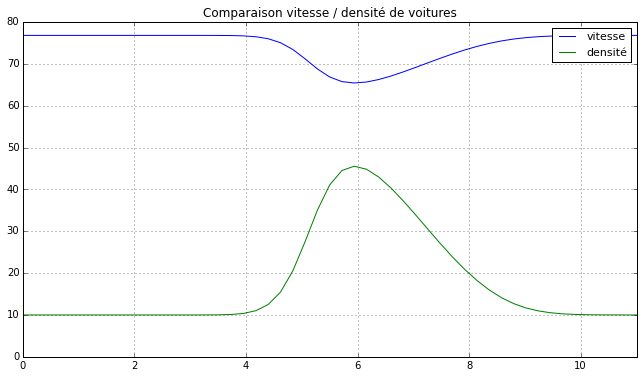

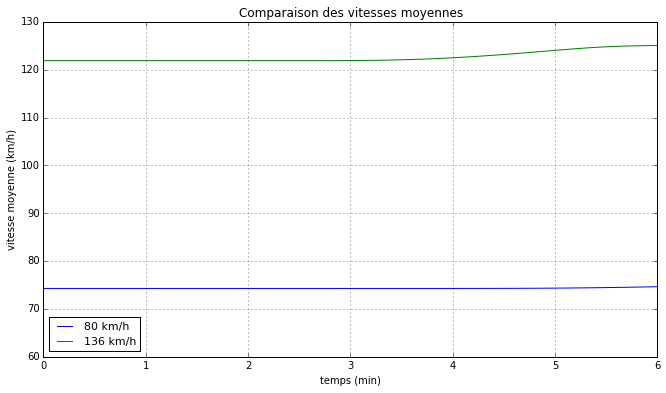

In [6]:
plt.figure(figsize=(11,6))
plt.grid(True)
plt.xlim(0,11)
plt.ylim(0,80)
plt.plot(x,v1[50])
plt.plot(x,rho1[50])
plt.legend(["vitesse","densité"],fontsize=11,loc=1)
plt.title("Comparaison vitesse / densité de voitures")
plt.show()

nt = int(6/60/Dt)+1
plt.figure(figsize=(11,6))
plt.grid(True)
plt.xlim(0,6)
plt.ylim(60,130)
plt.xlabel("temps (min)")
plt.ylabel("vitesse moyenne (km/h)")
plt.plot(np.linspace(0,6,nt),vm1)
plt.plot(np.linspace(0,6,nt),vm2)
plt.legend(["80 km/h","136 km/h"],fontsize=11,loc=3)
plt.title("Comparaison des vitesses moyennes")
plt.show()


Le graphique ci-dessus va nous permettre d'analyser la vitesse moyenne pour les deux solutions.

On voit bien que la vitesse moyenne est approximativement constante et que les deux valeurs ont l'air d'être multiple l'une de l'autre. Cependant, on voit qu'à la fin de la simulation, on a un légère courbure de la ligne verte, celle où la $V_{max} = 136$ km/h. Cela est dû au fait que pour celle-ci, le bouchon sur la section de la route se réduit ce qui induit que son influence sur la vitesse moyenne devient négligeable. 

Nous utilisons une petite annimation pour terminer notre analyse dont voici le code.

In [14]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation

def visual(ls,labelx,labely):
    """
    recupere un tableau NxQ et en fait une annimantion
    """
    fig=plt.figure(figsize=(8,5))
    ax=plt.axes(xlim=(0,11),ylim=(min(ls[1])-5,max(ls[1])+5),xlabel = labelx,ylabel=labely)
    line=ax.plot([],[],ls='--')[0]
    lis = np.ones(nx)
    def anim(i):
        line.set_data(x,lis)
        lis[:]=ls[i]
    return animation.FuncAnimation(fig, anim,
                        frames=len(ls),interval=100)


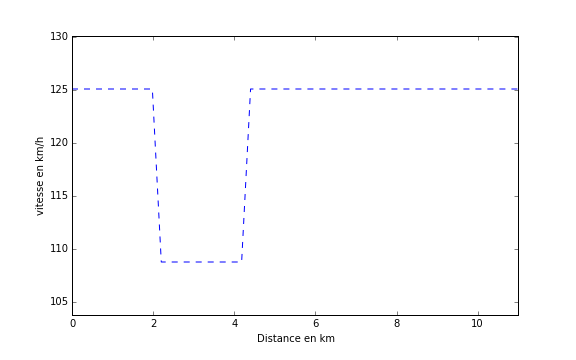
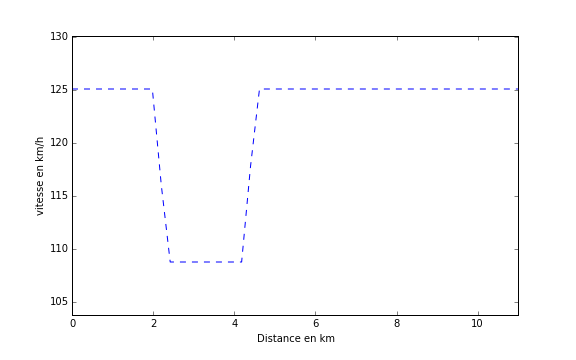
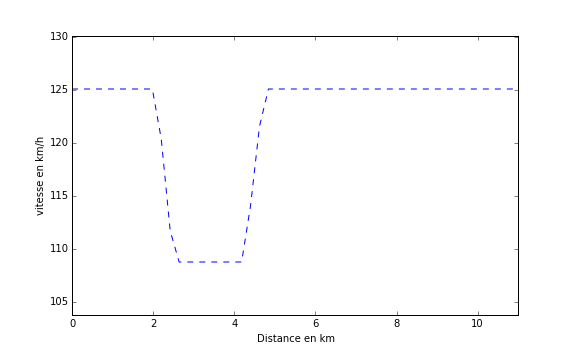
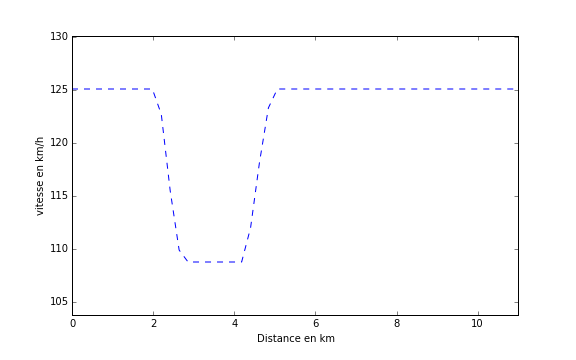
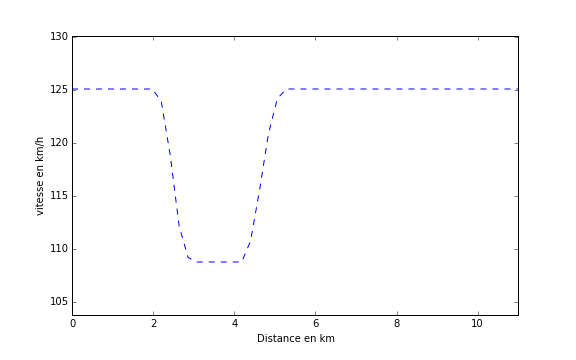
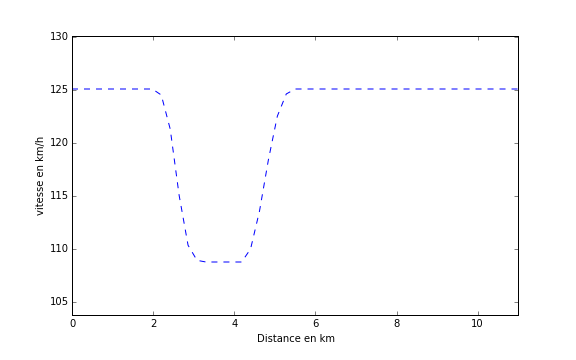
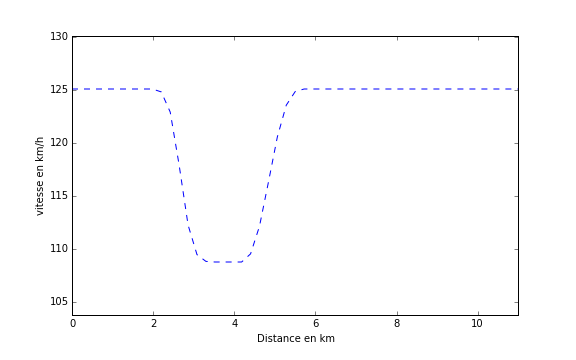
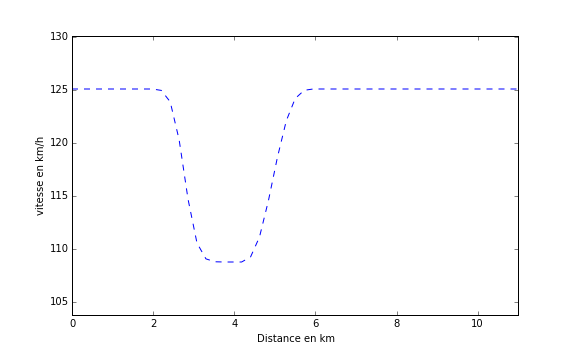
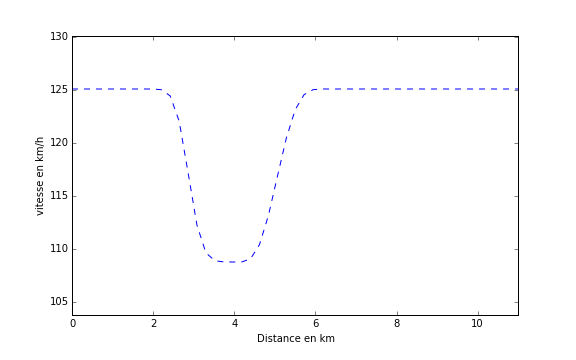
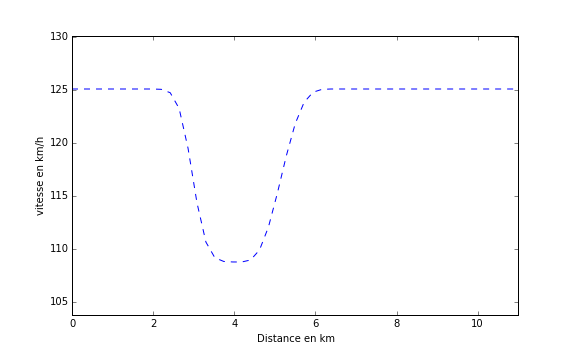
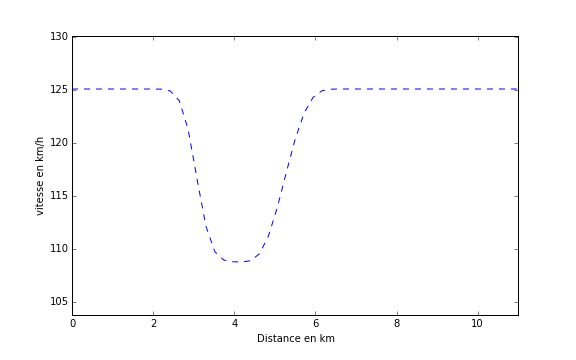
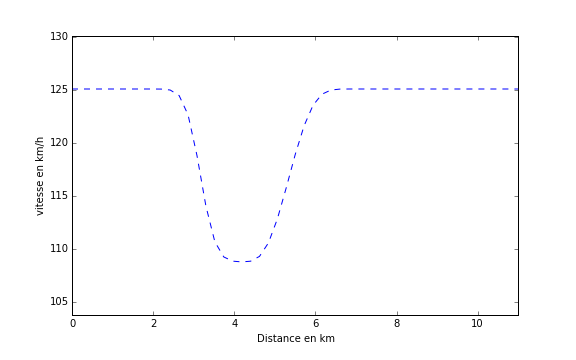
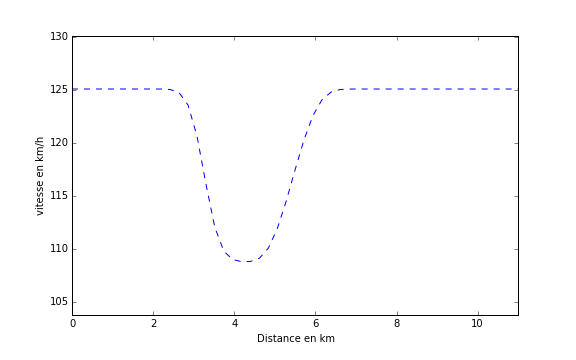
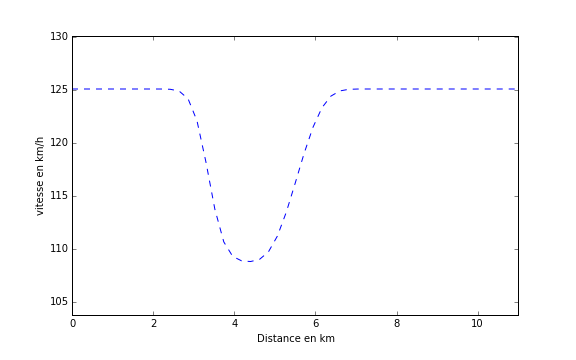
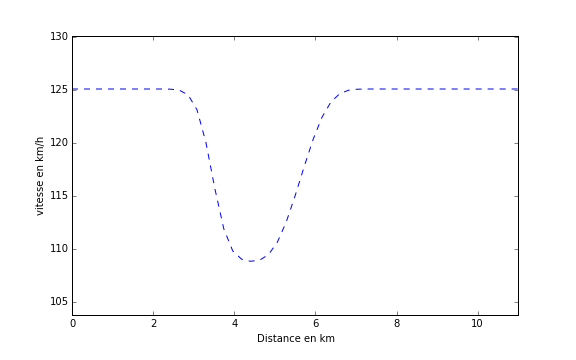
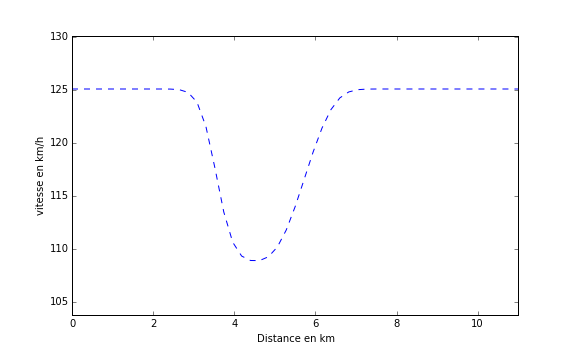
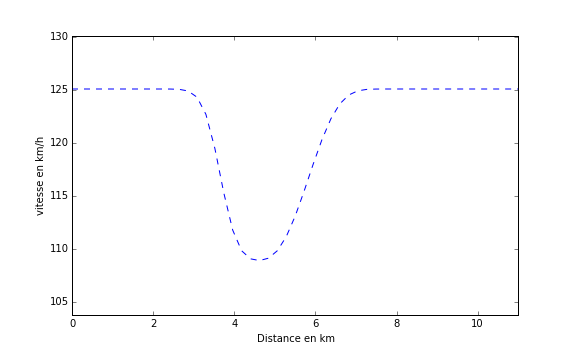
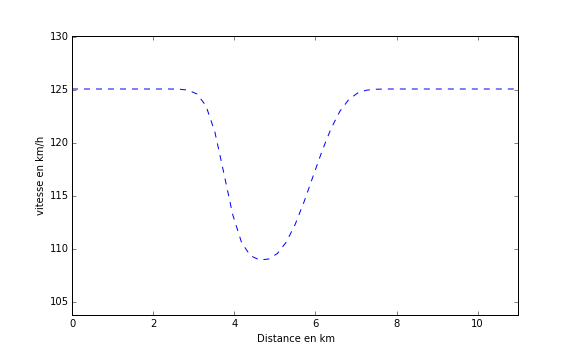
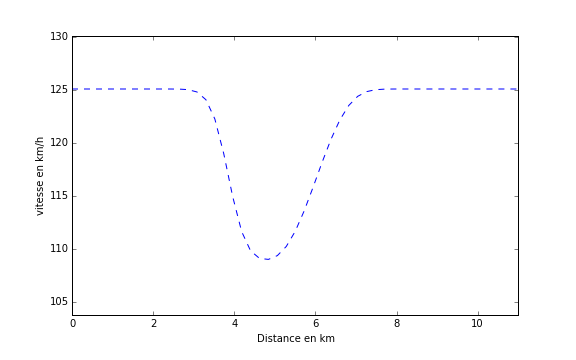
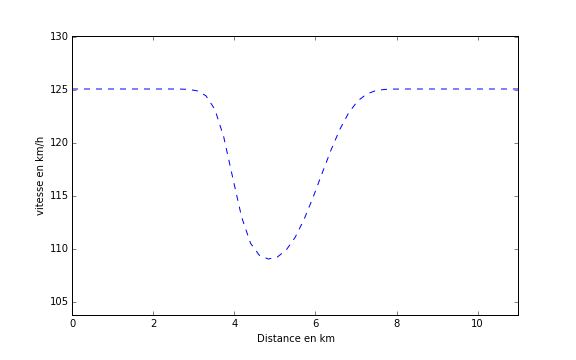
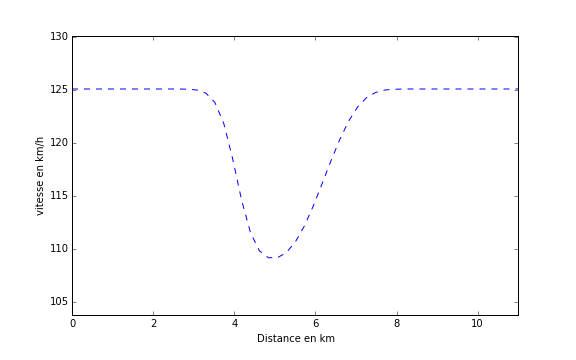
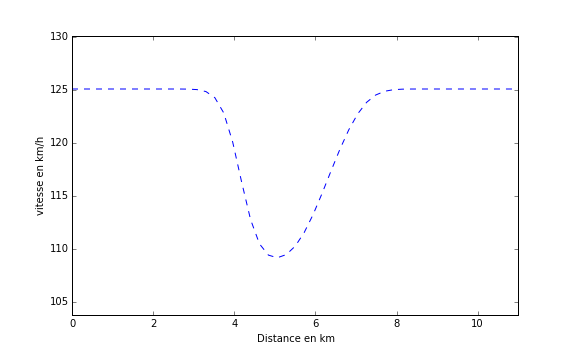
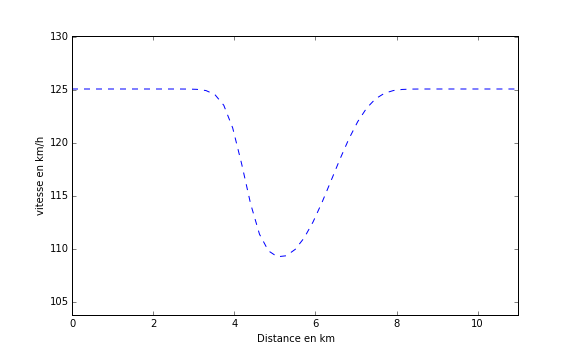
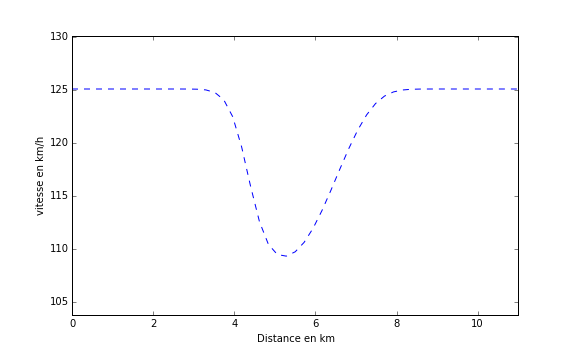
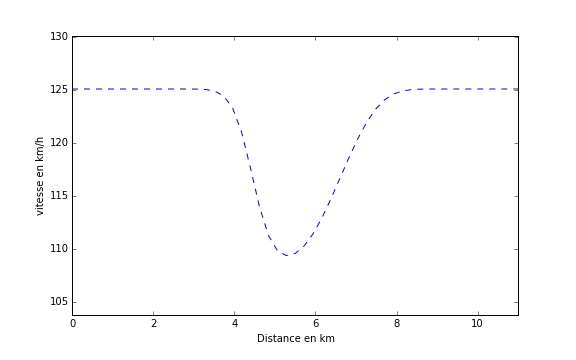
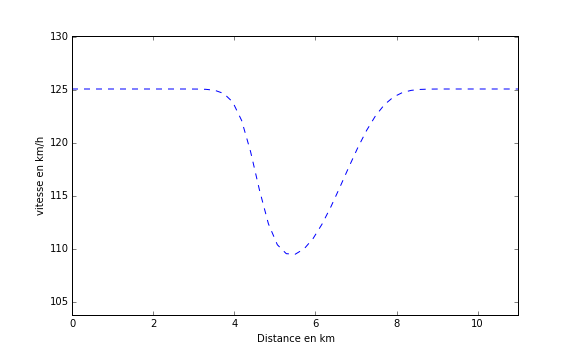
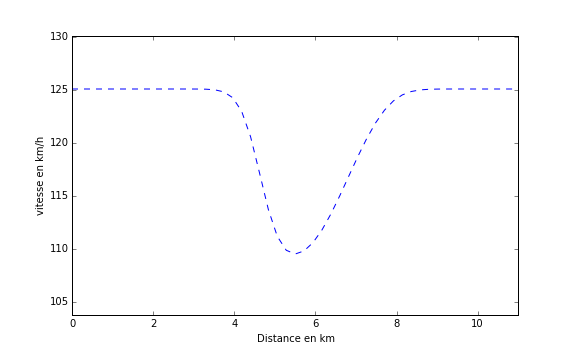
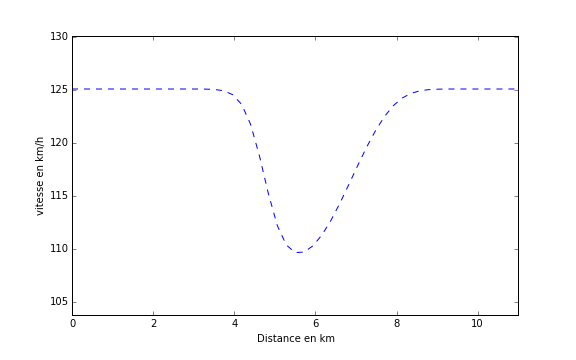
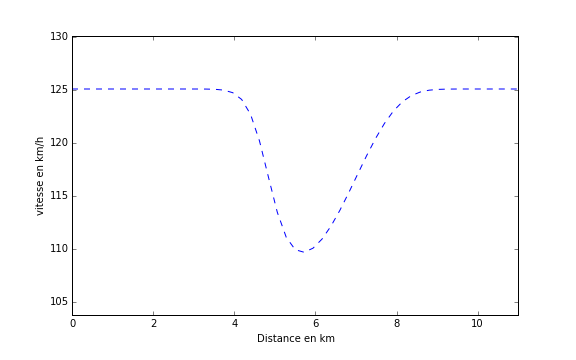
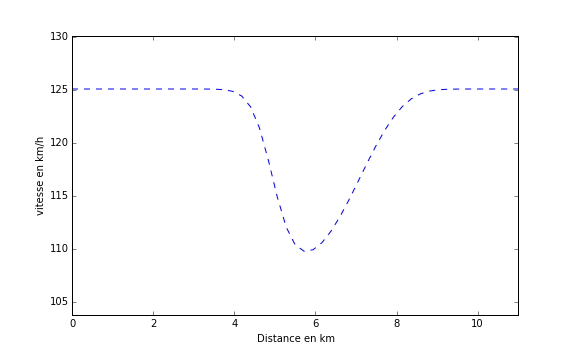
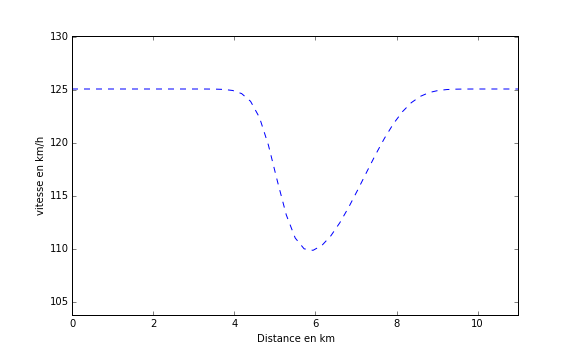
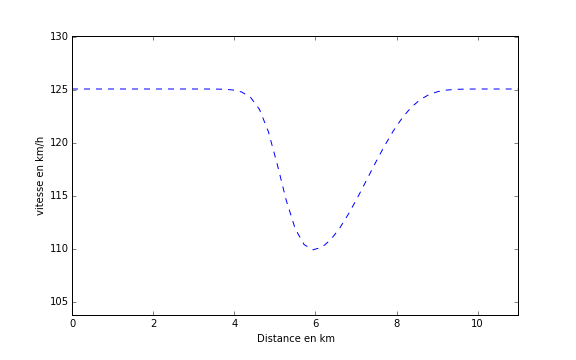
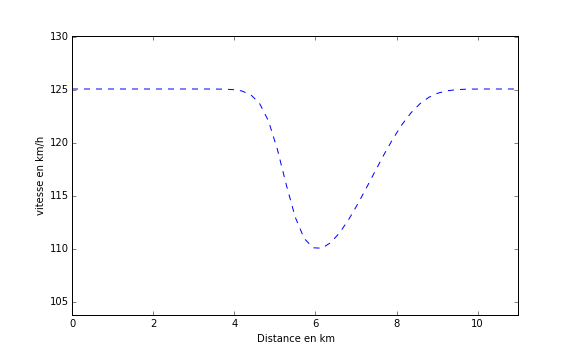
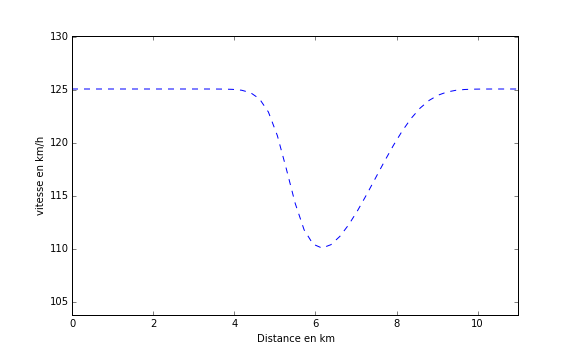
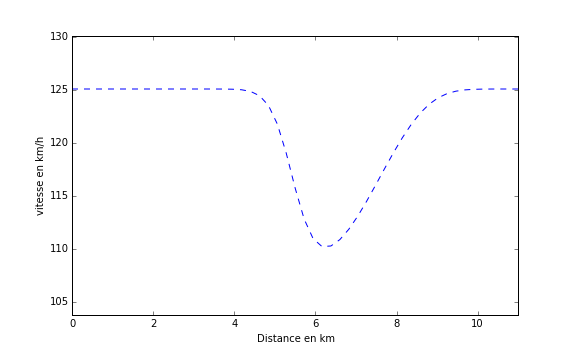
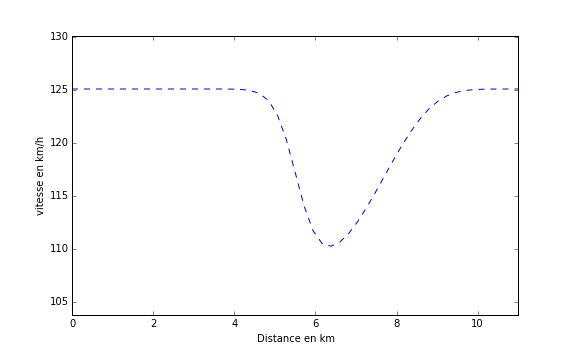
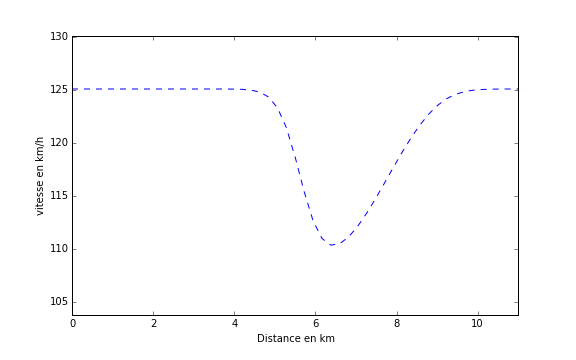
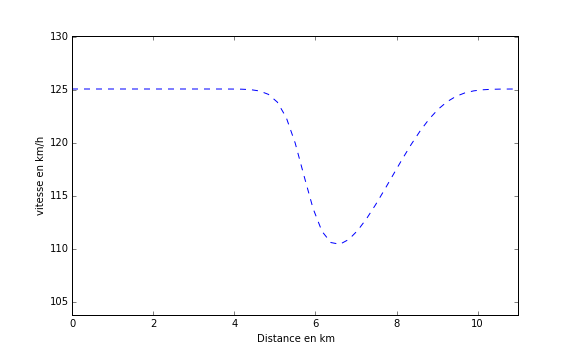
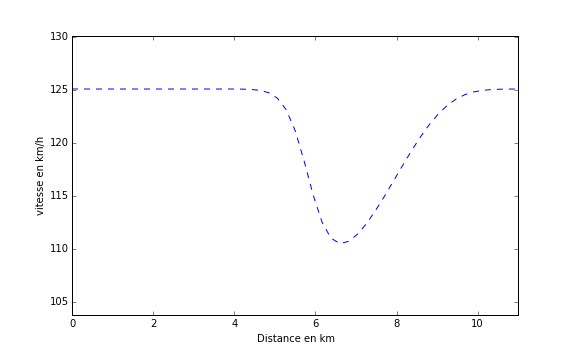
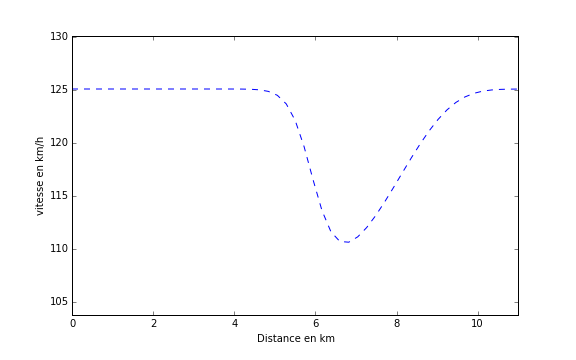
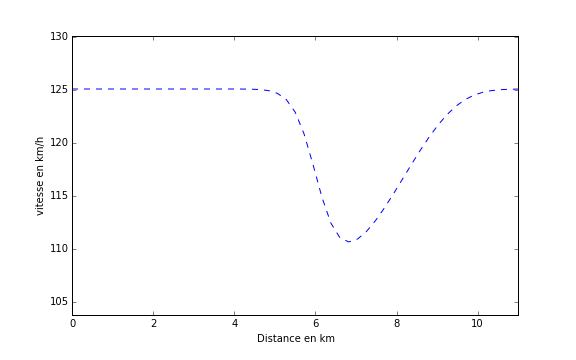
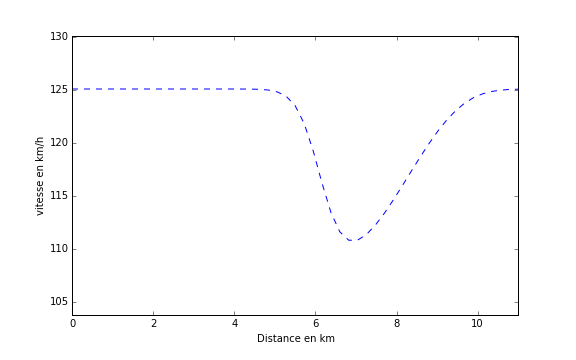
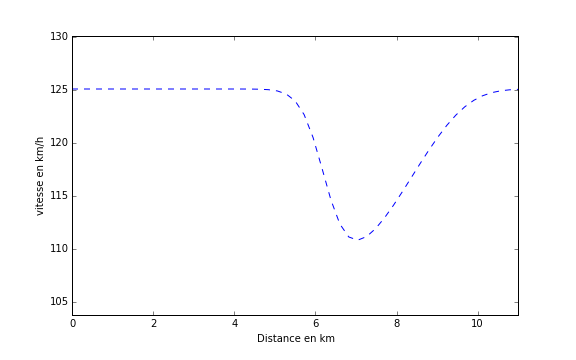
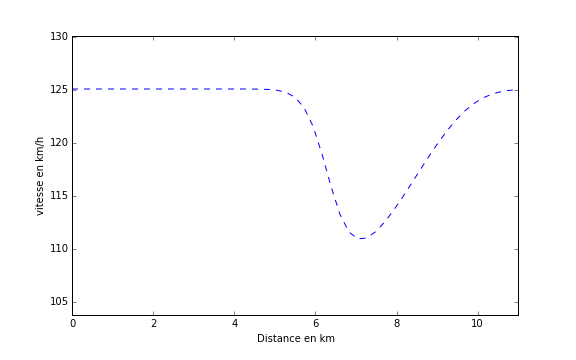
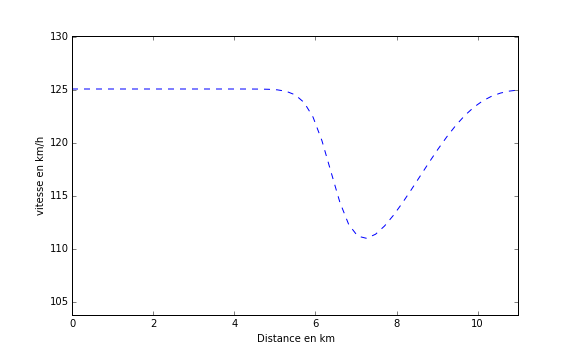
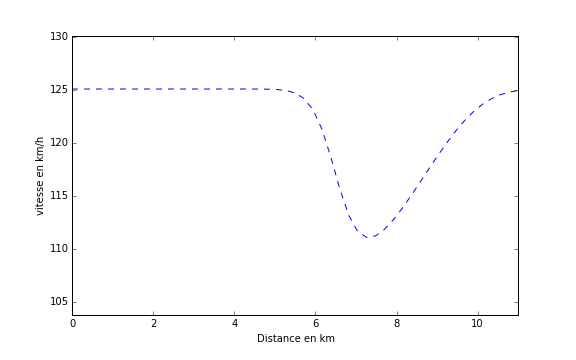
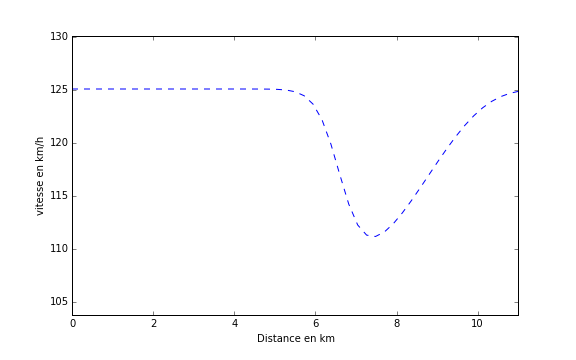
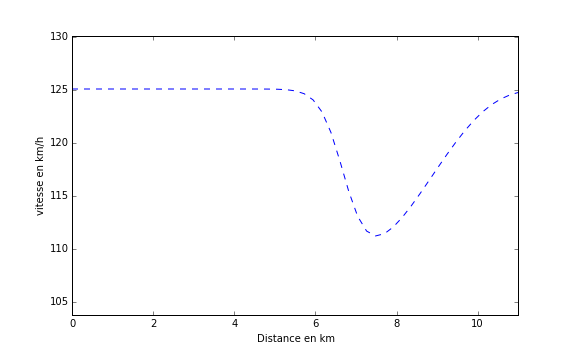
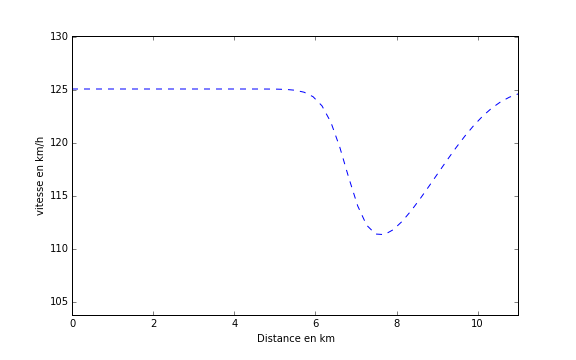
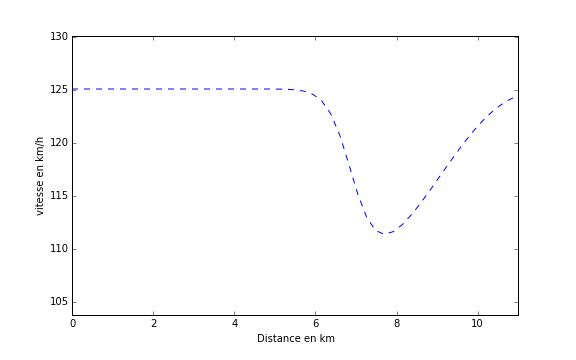
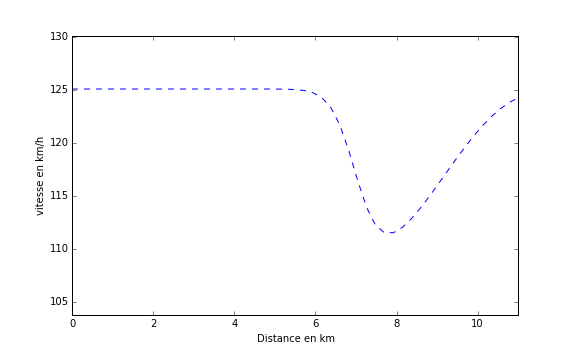
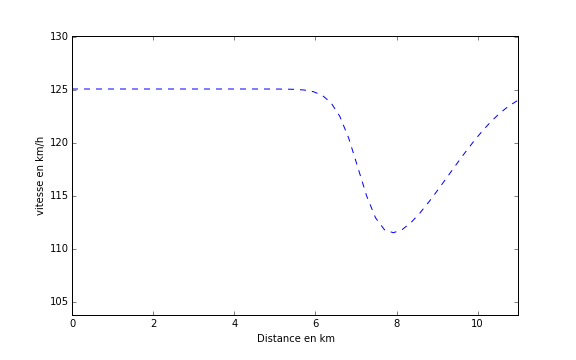
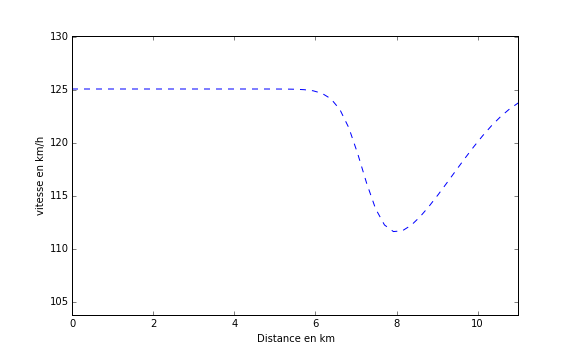
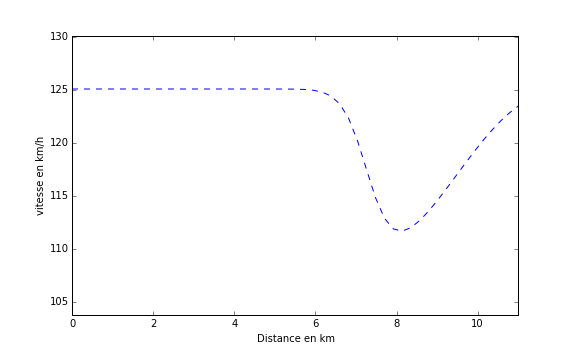
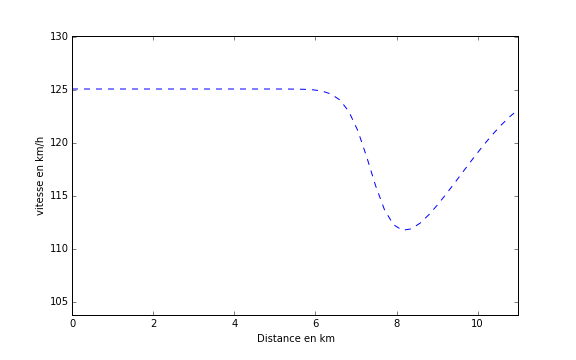
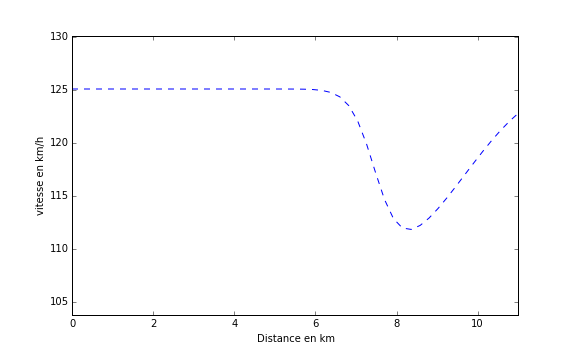
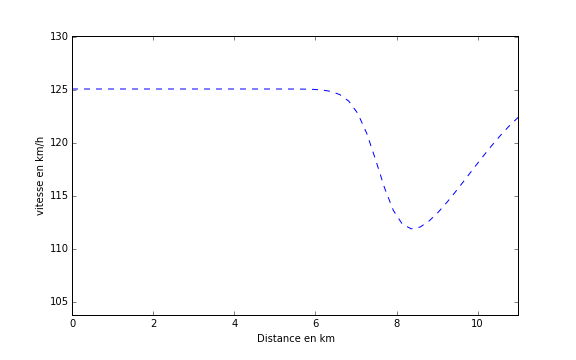
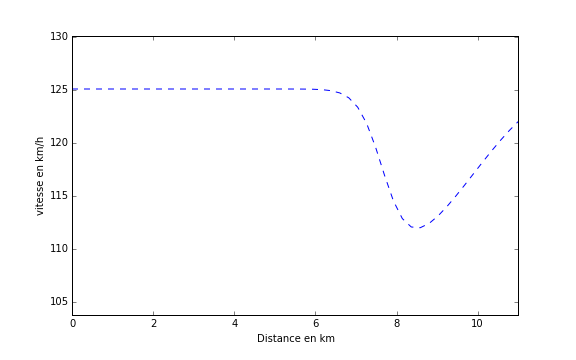
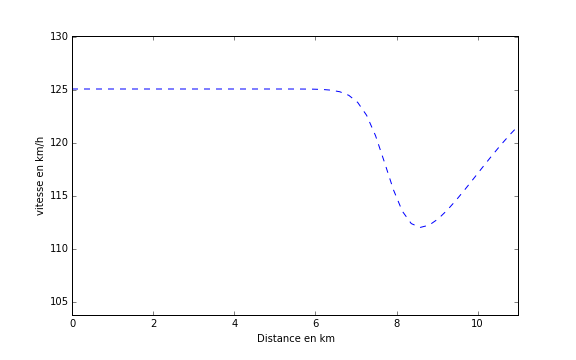
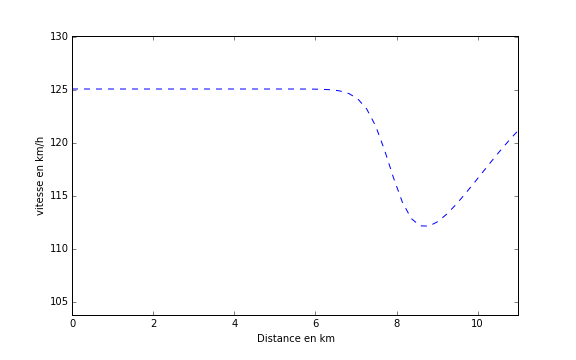
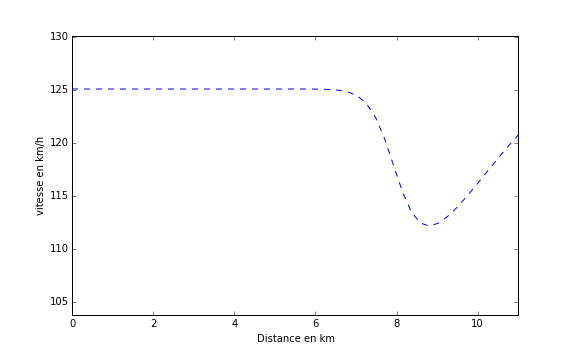
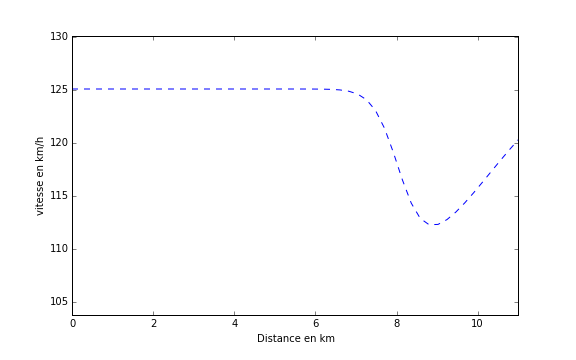
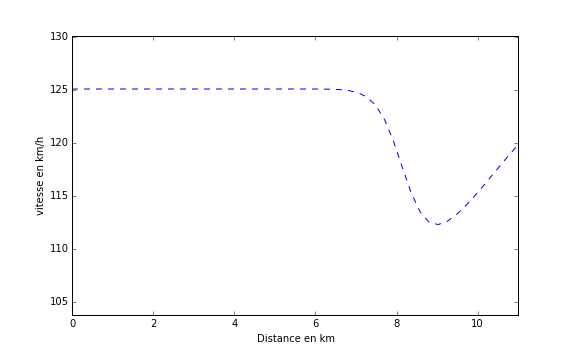
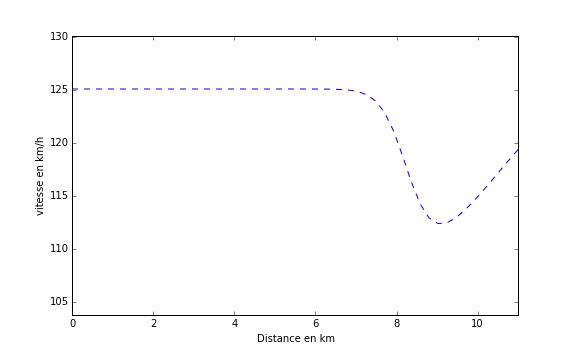
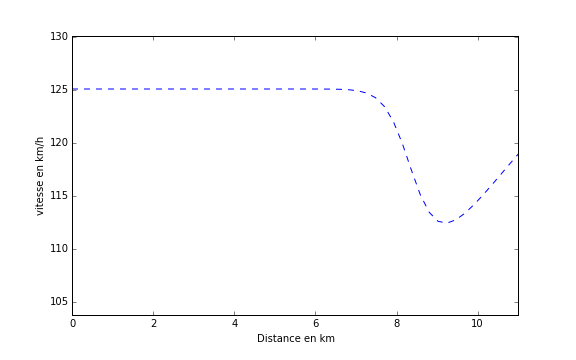
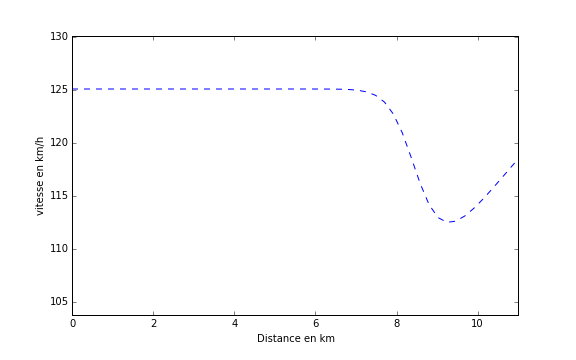
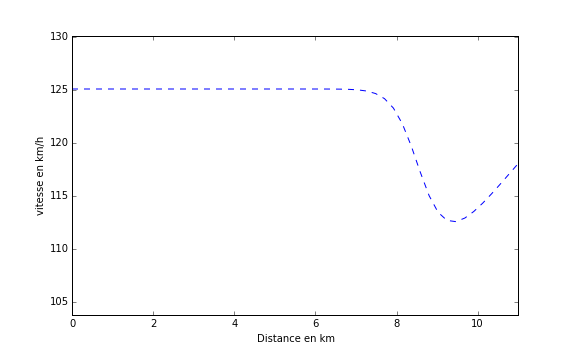
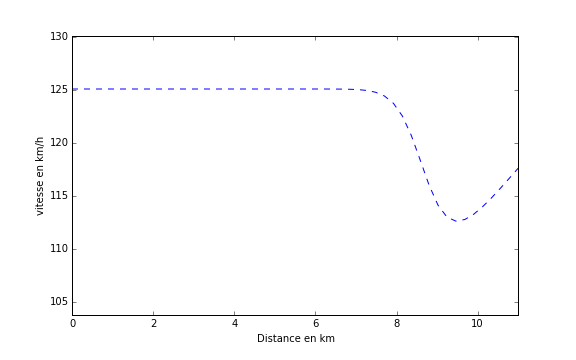
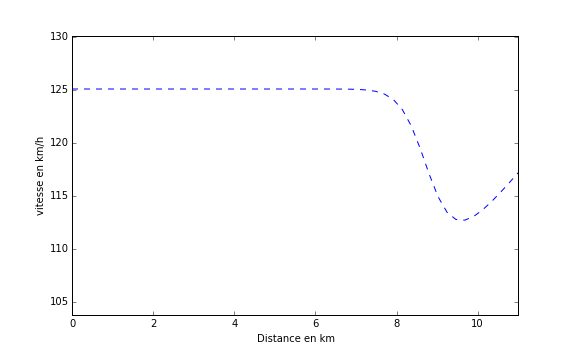
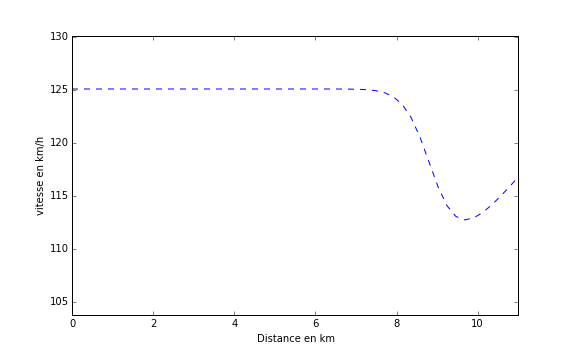
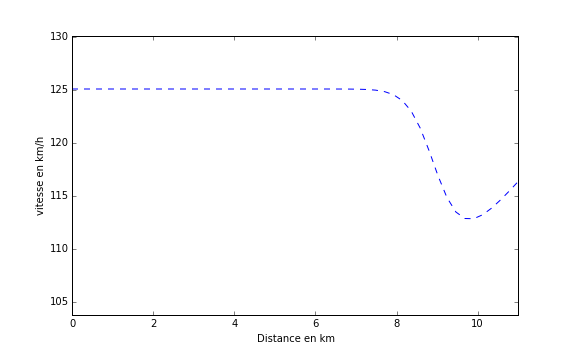
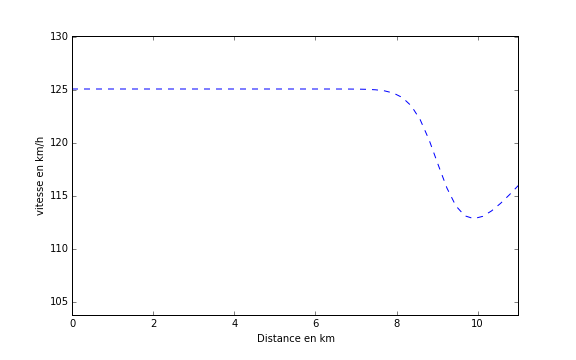
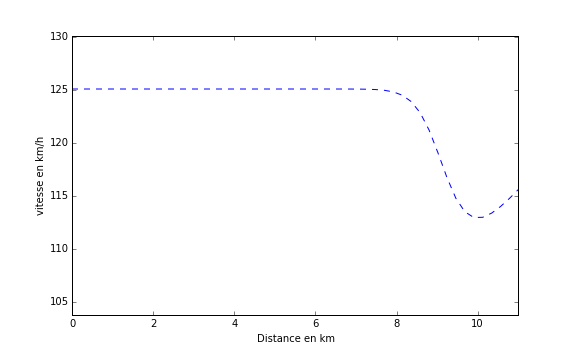
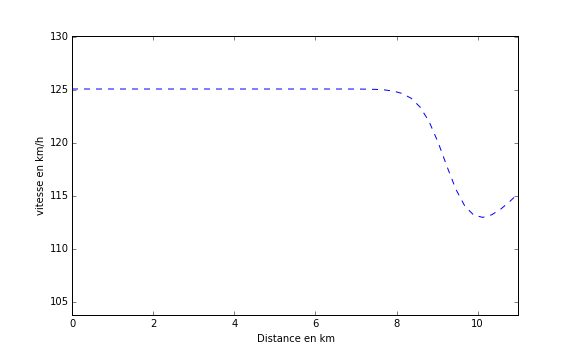
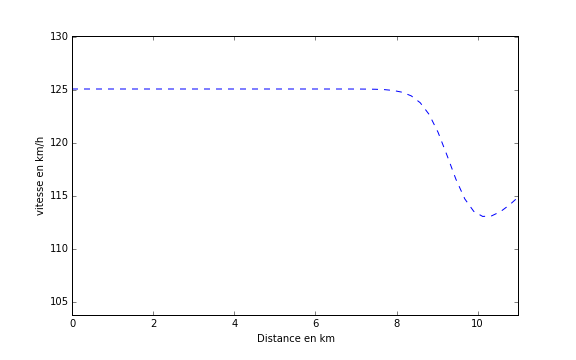
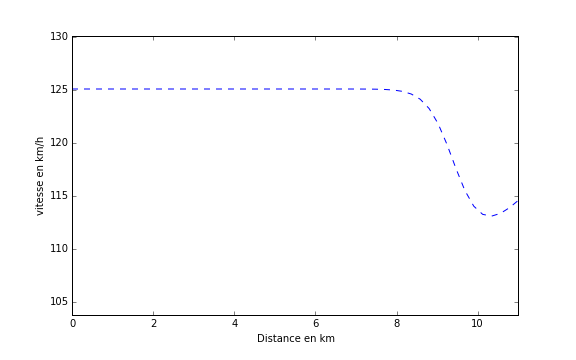
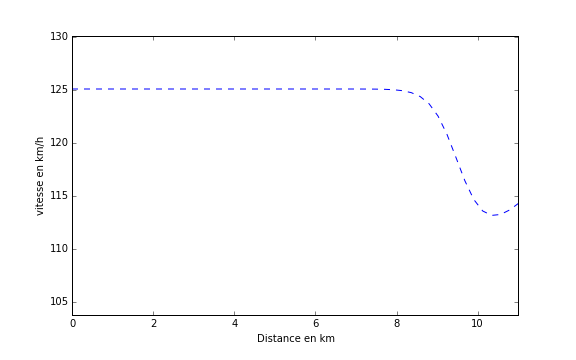
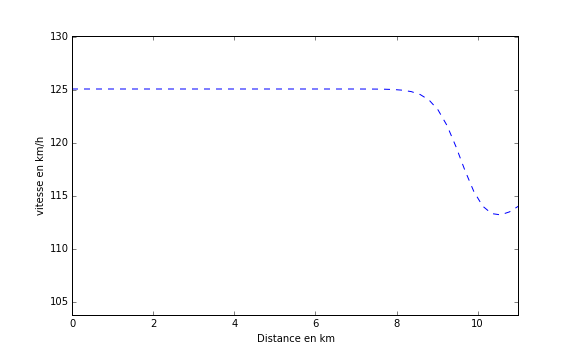
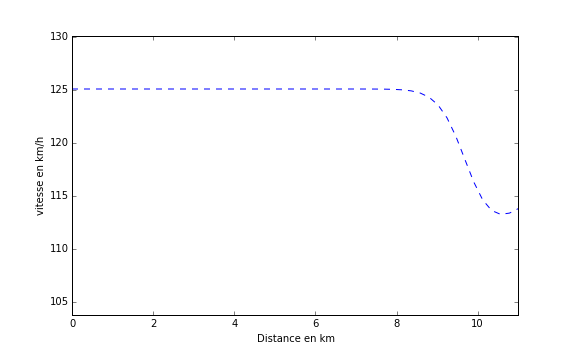
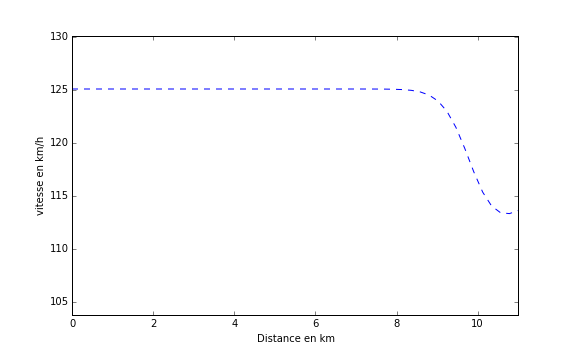
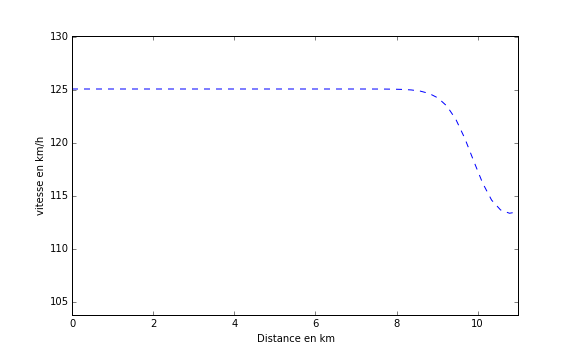
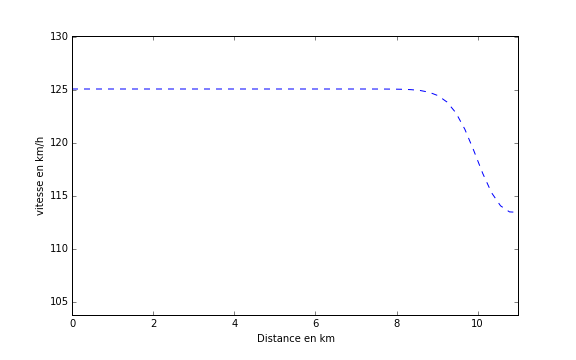
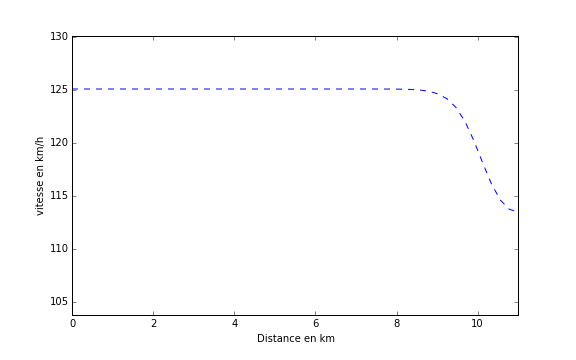
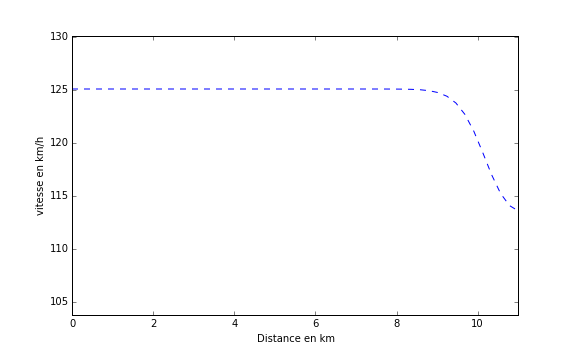
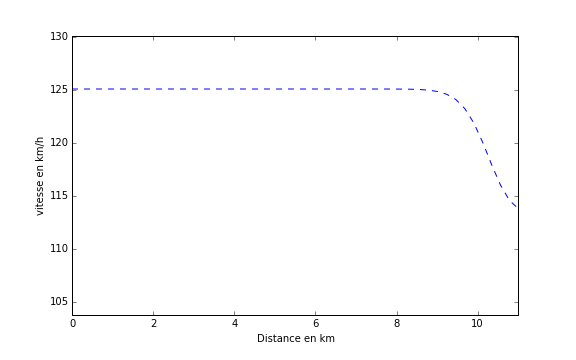
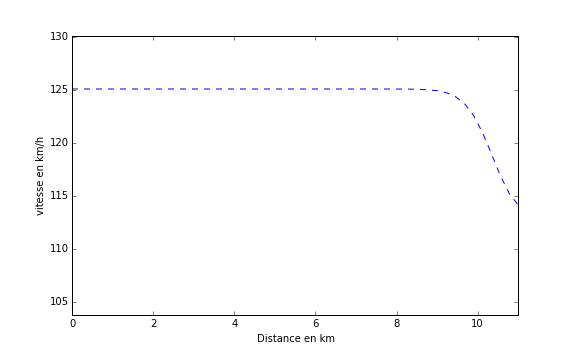
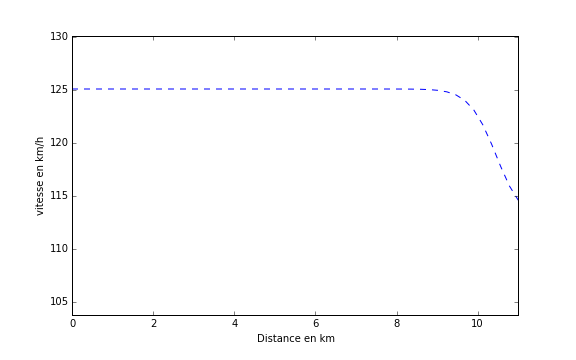
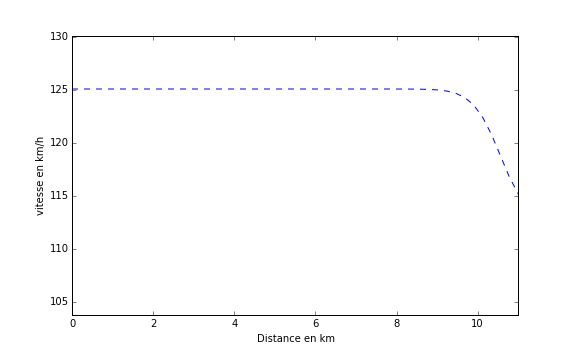
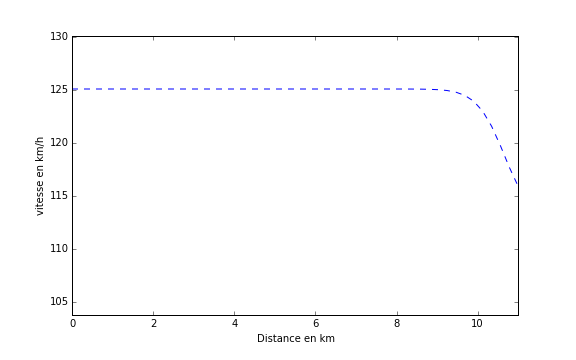
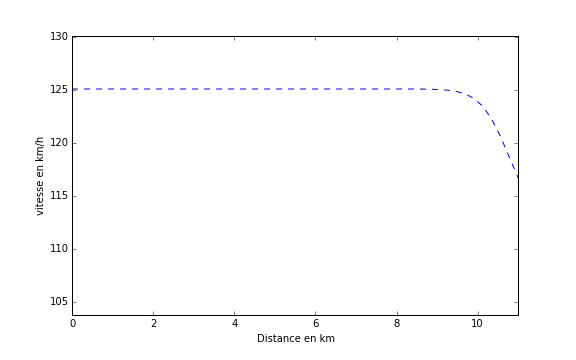
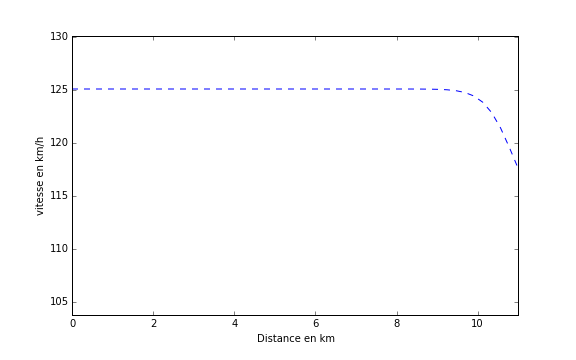
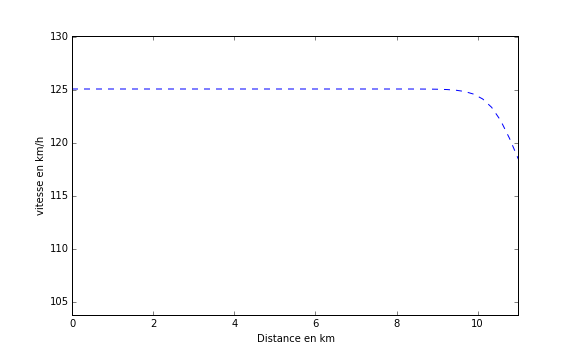
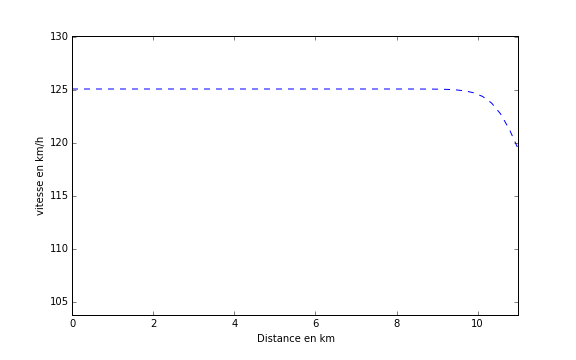
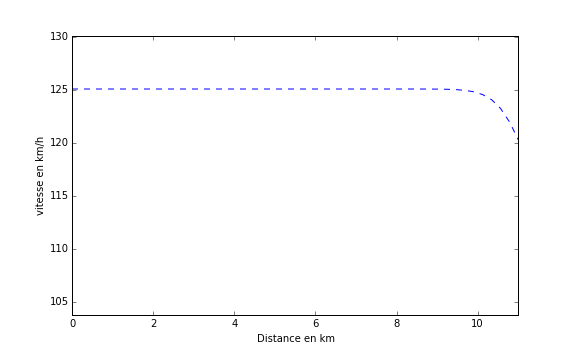
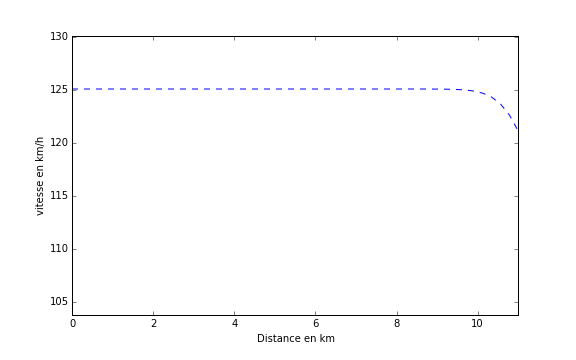
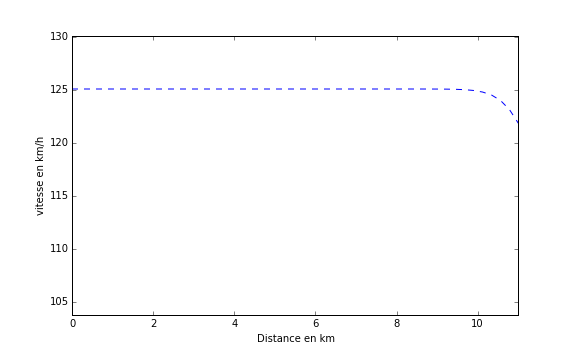
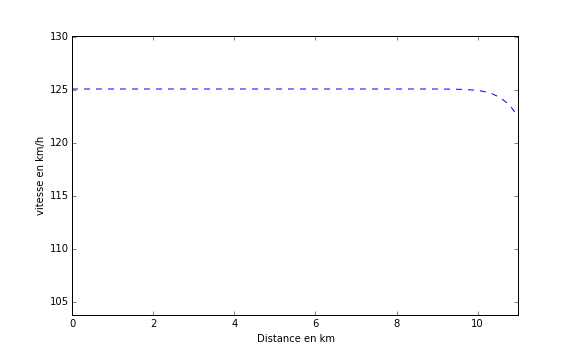
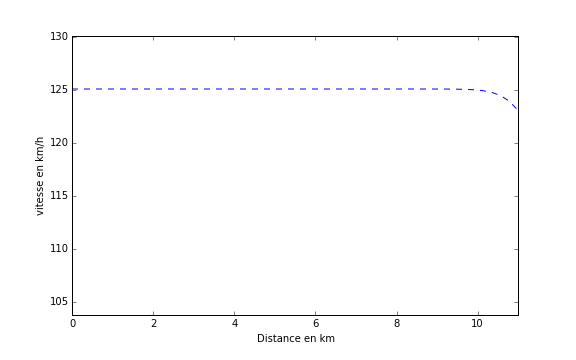
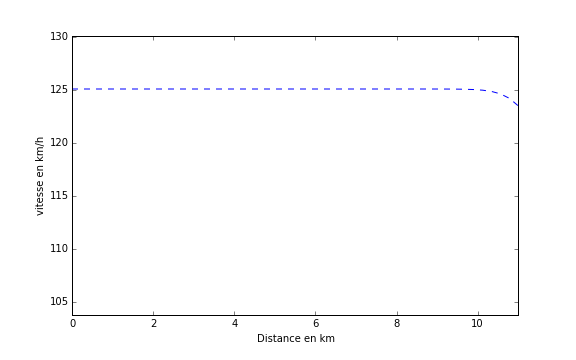
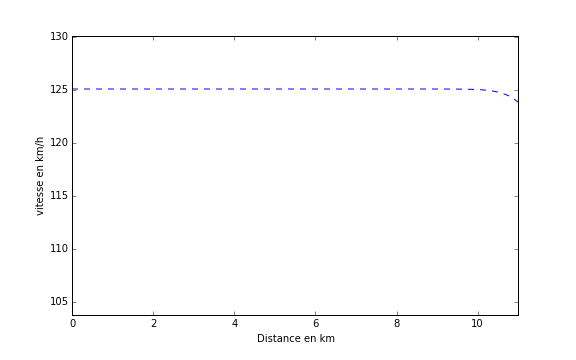
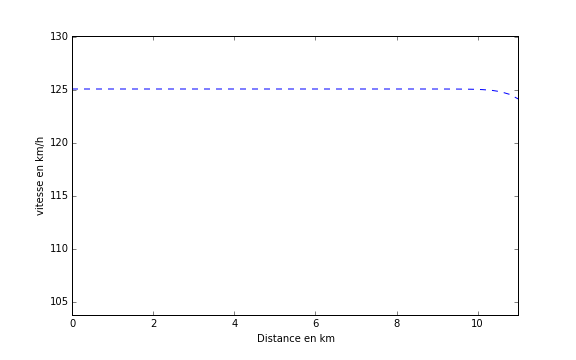

In [15]:
v,rho,vm = Traffic(50,20,136,6) 
visual(v,"Distance en km","vitesse en km/h")


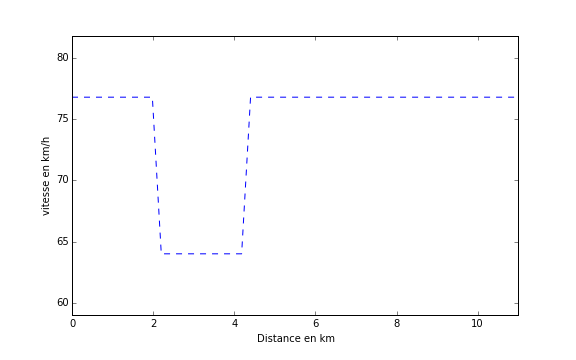
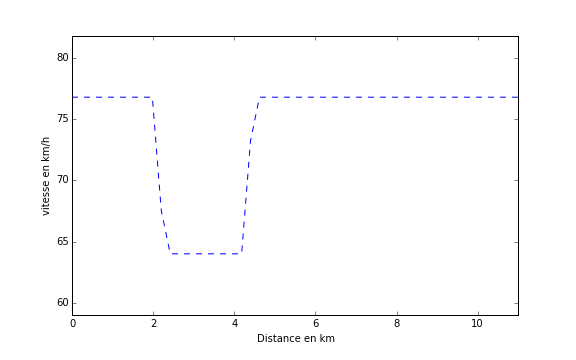
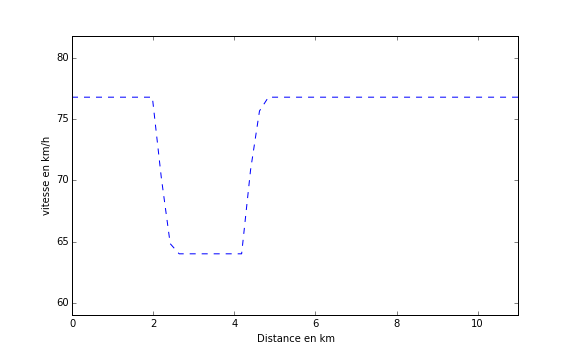
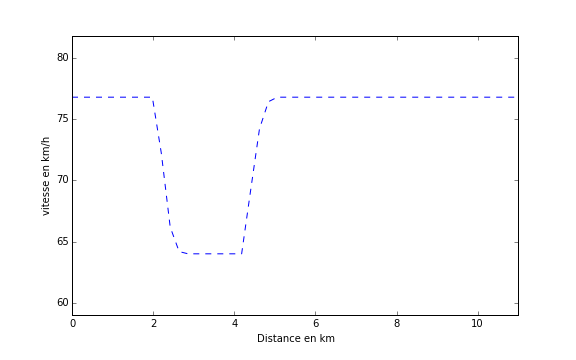
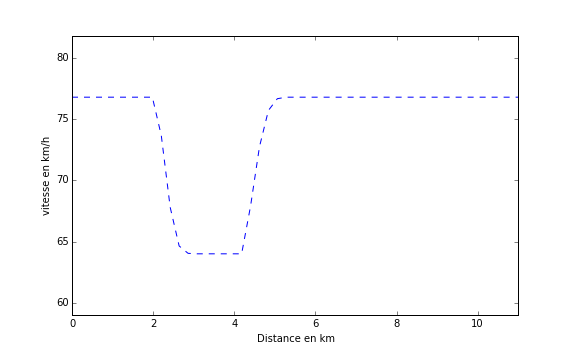
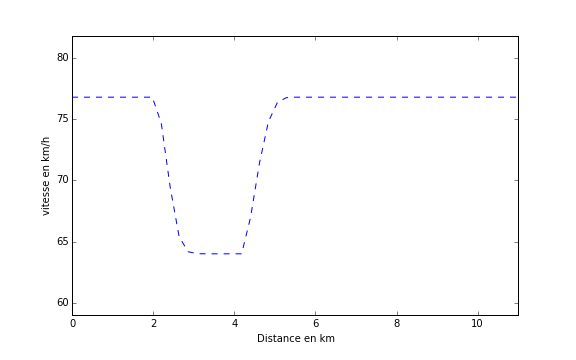
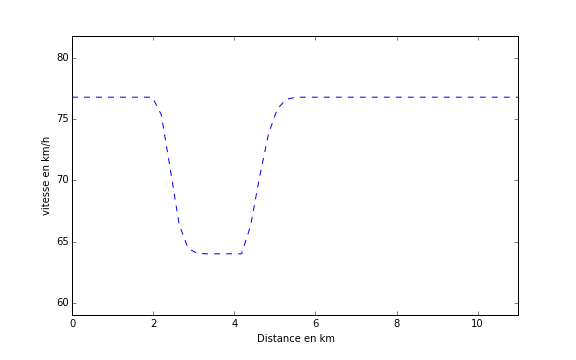
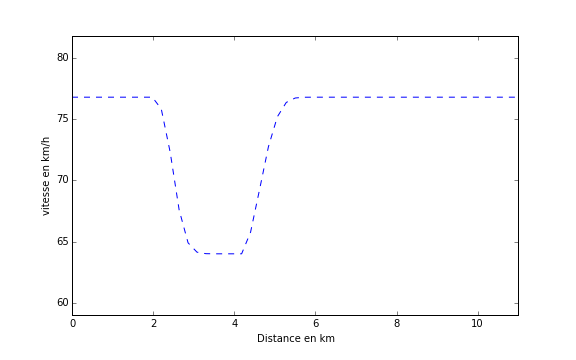
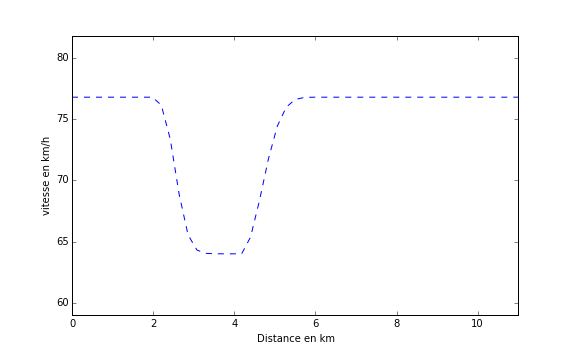
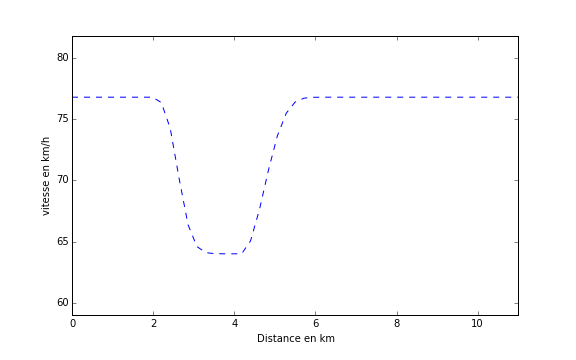
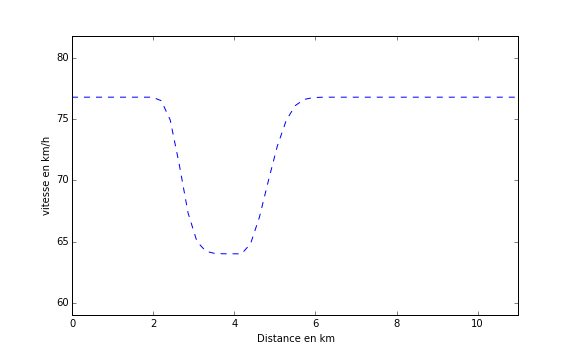
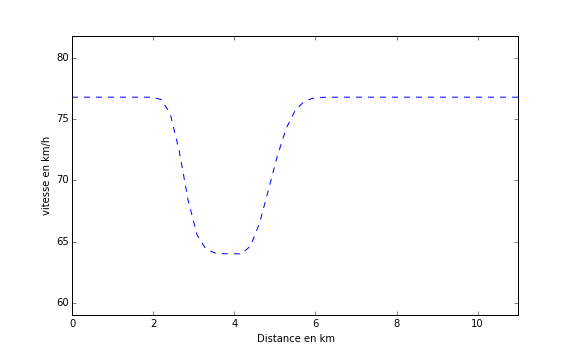
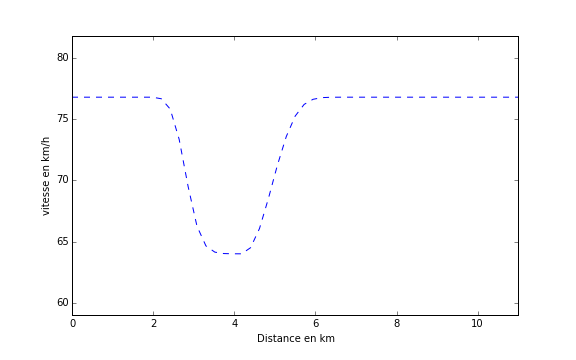
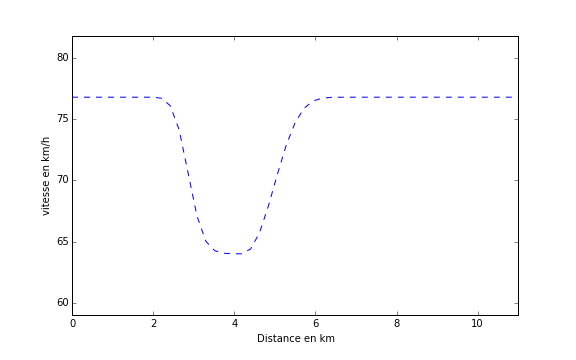
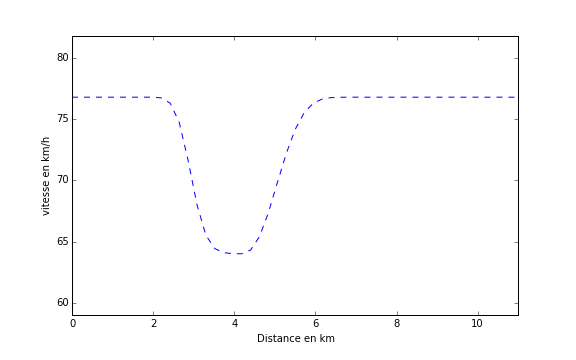
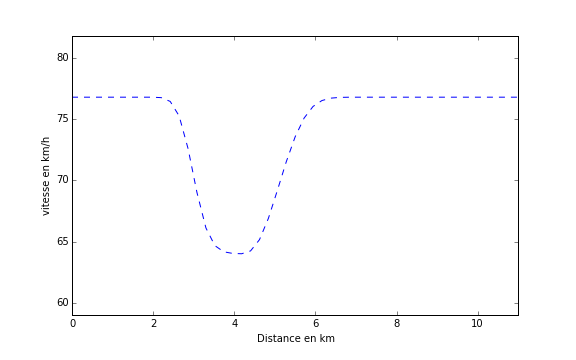
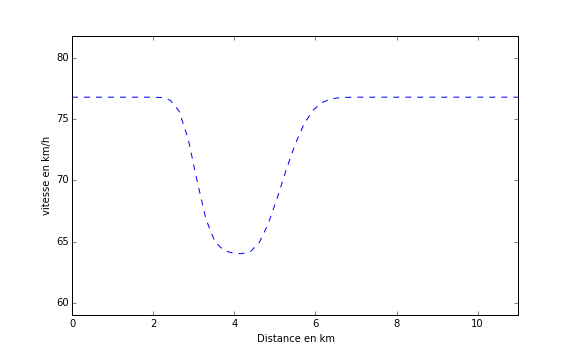
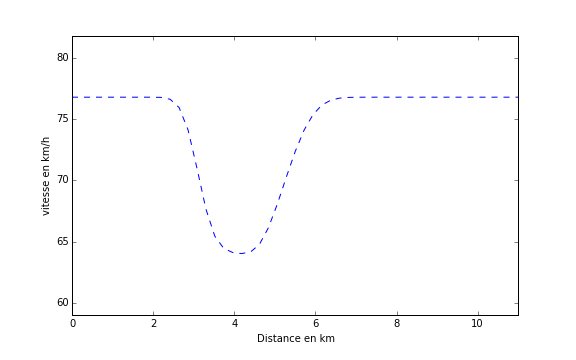
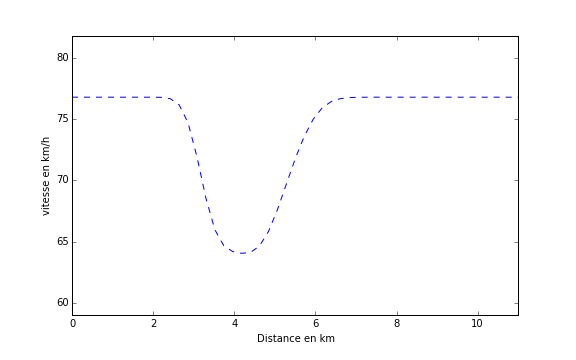
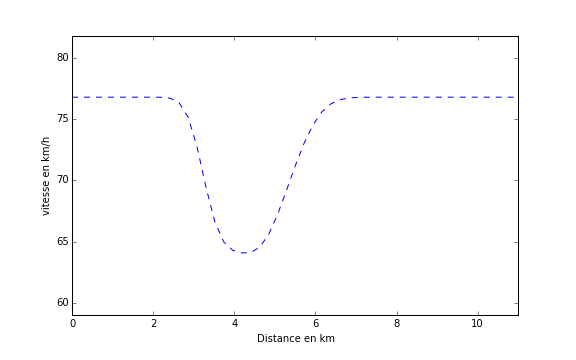
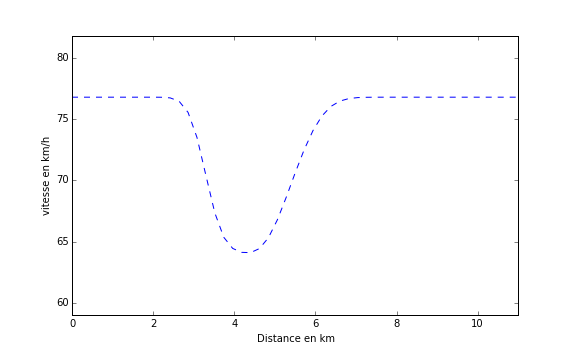
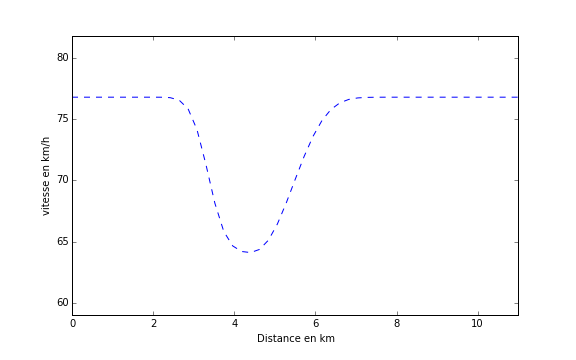
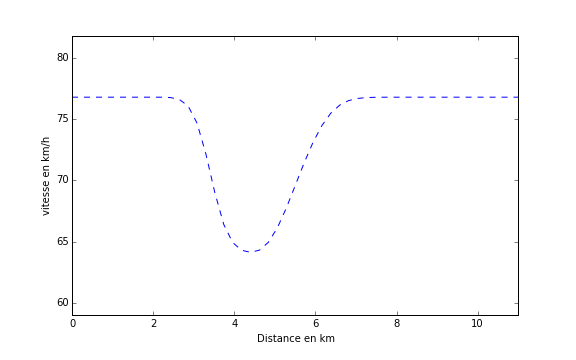
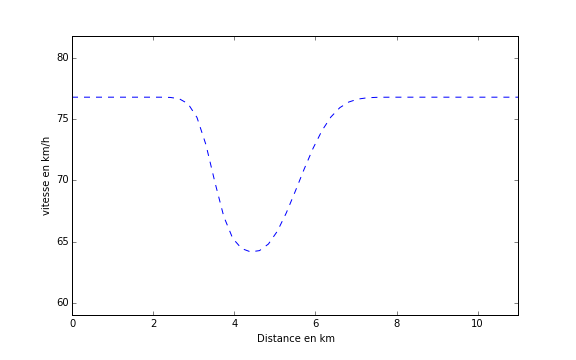
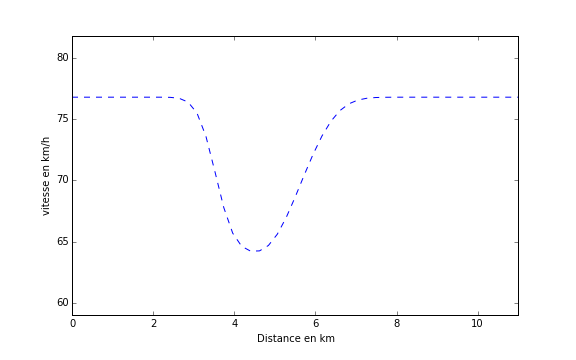
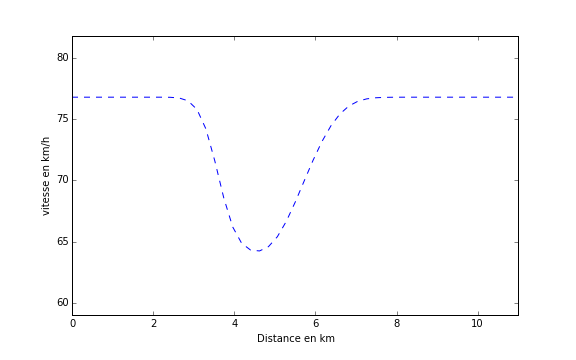
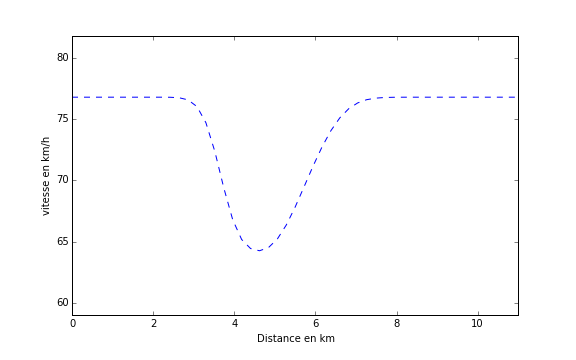
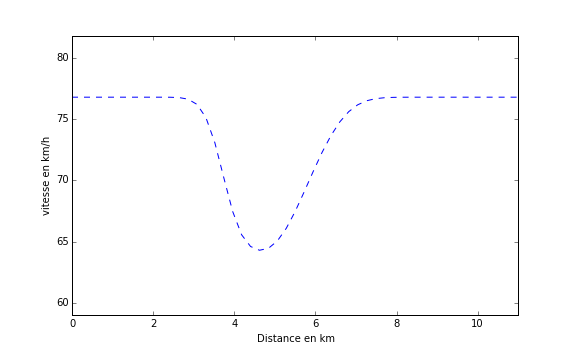
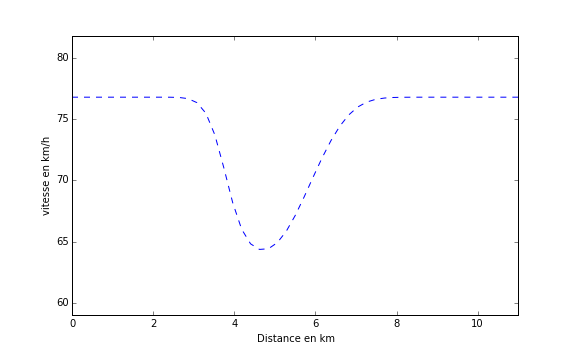
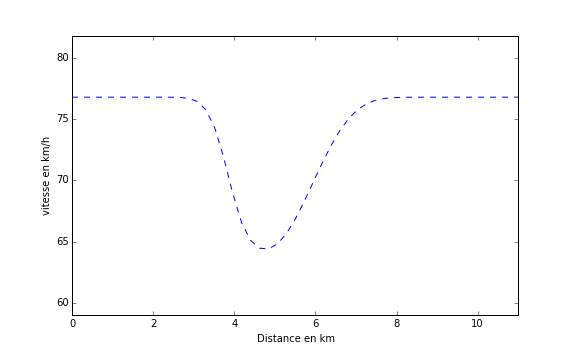
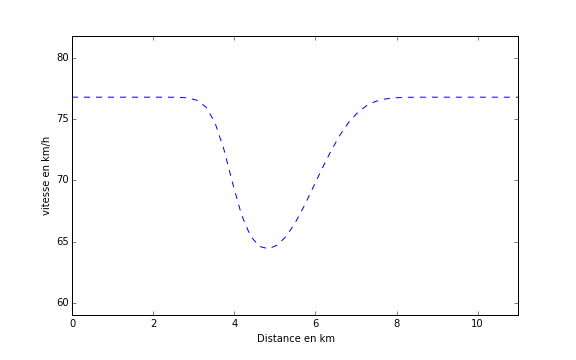
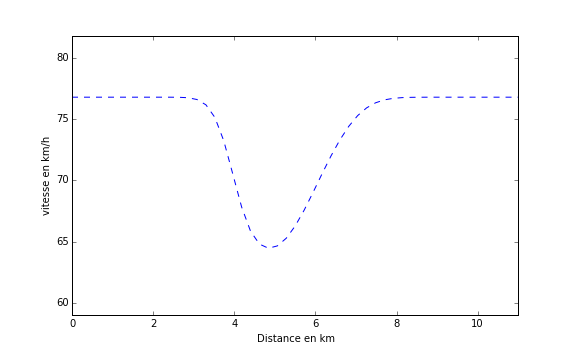
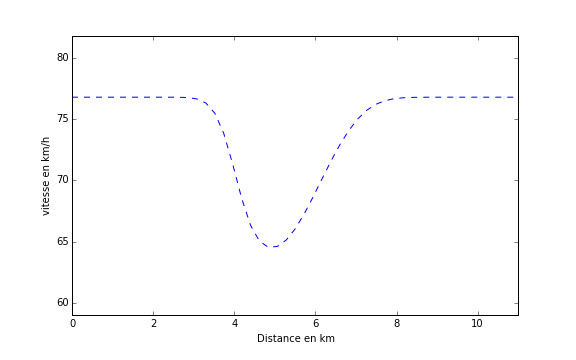
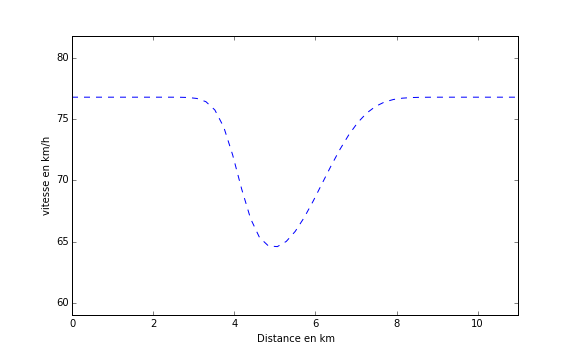
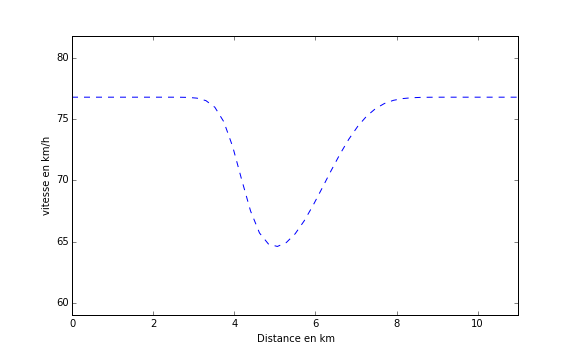
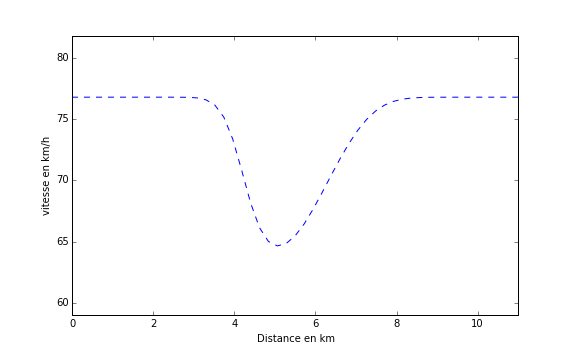
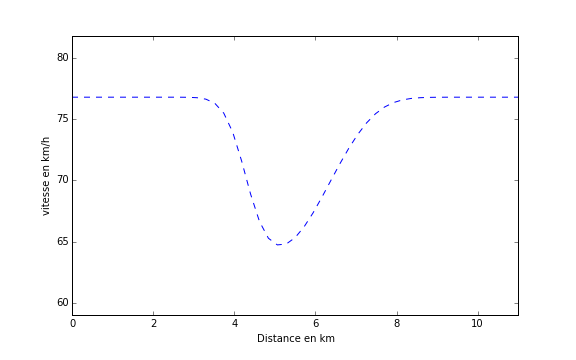
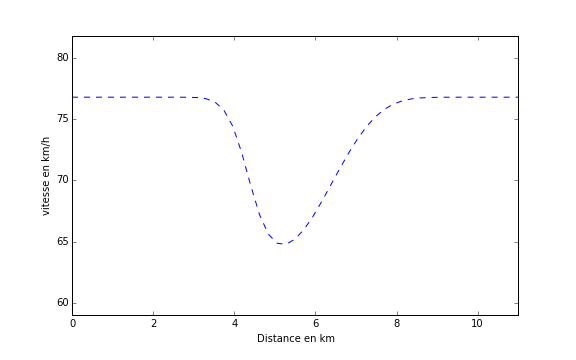
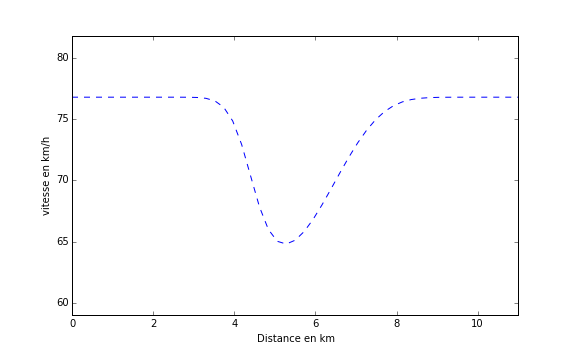
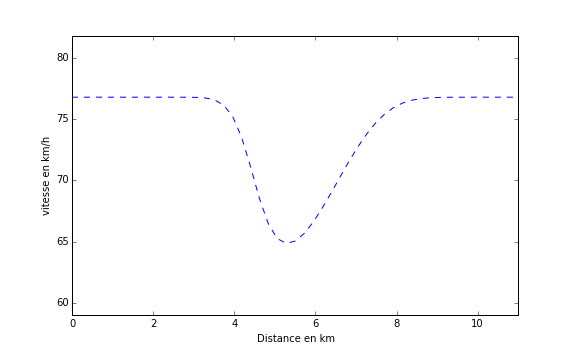
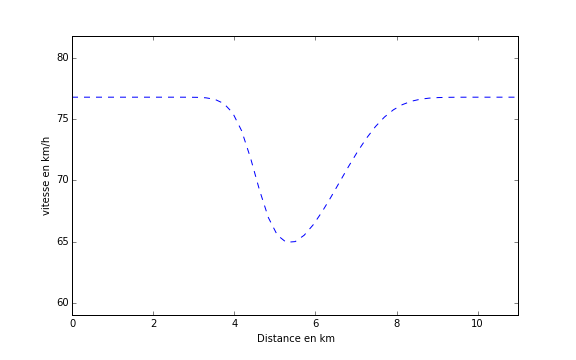
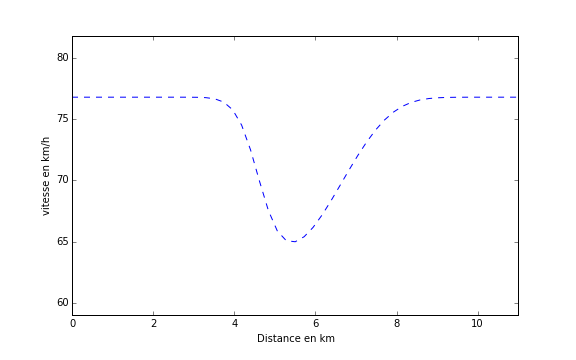
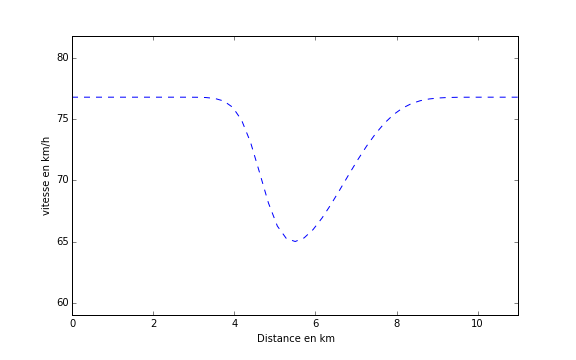
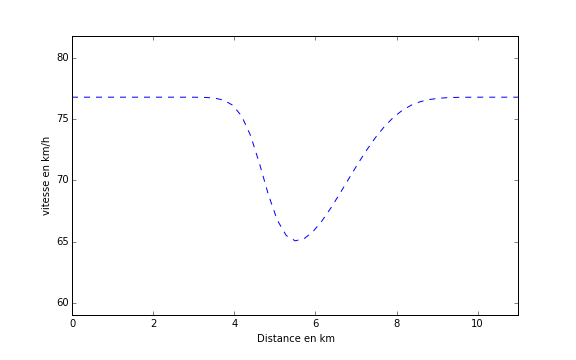
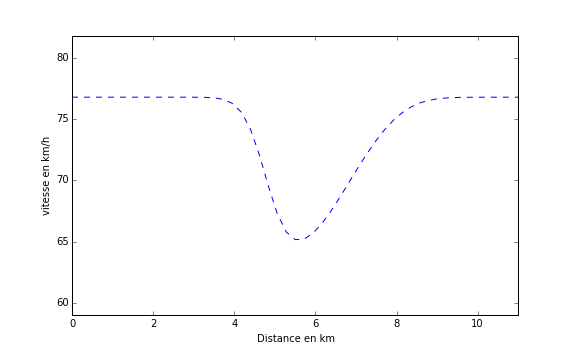
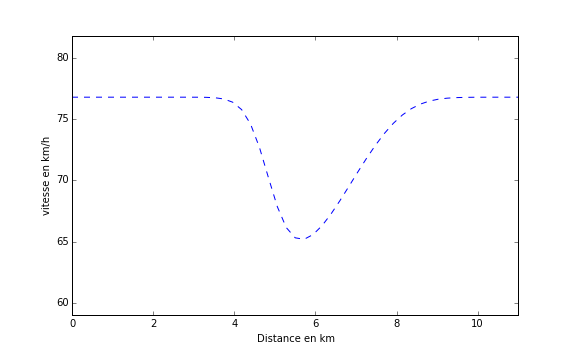
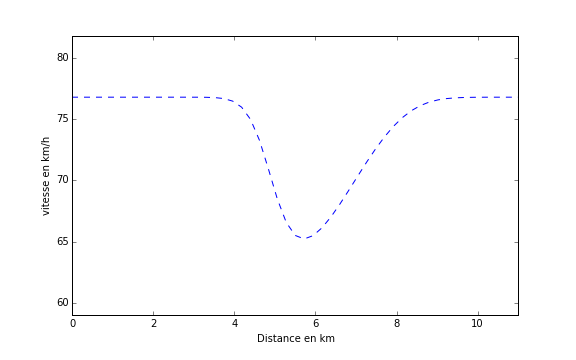
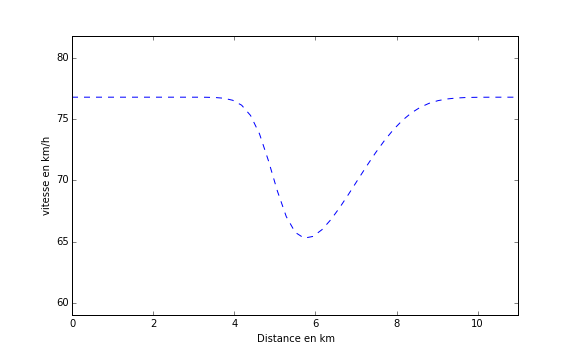
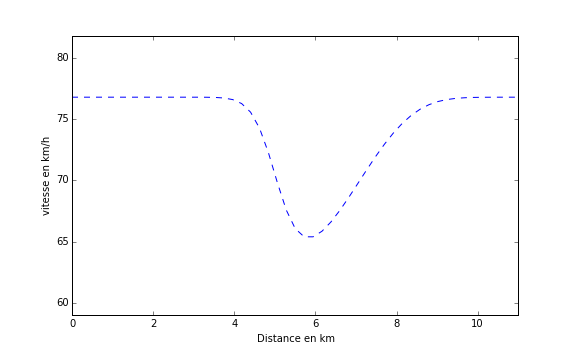
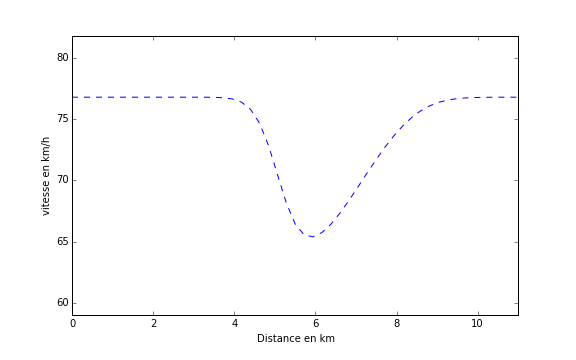
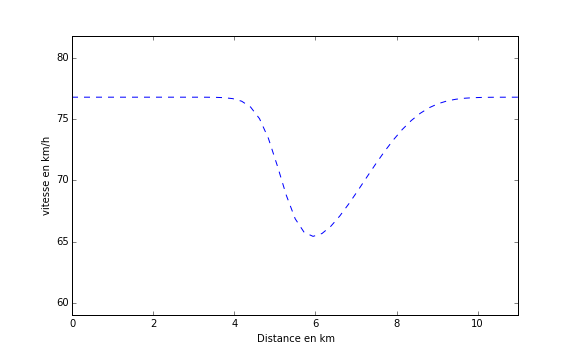
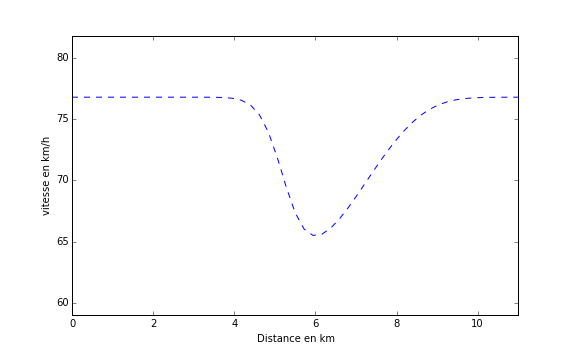
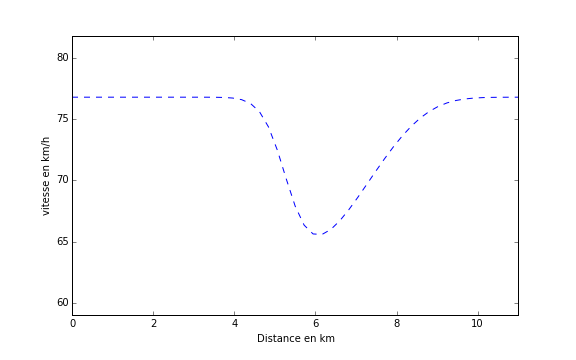
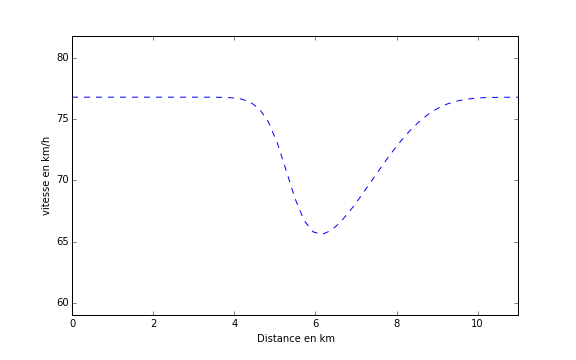
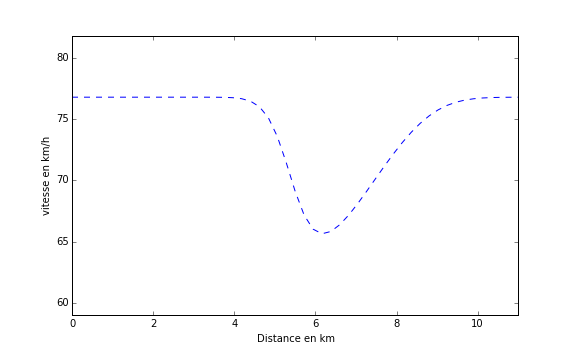
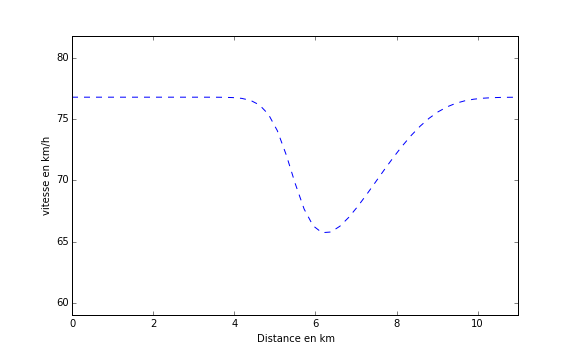
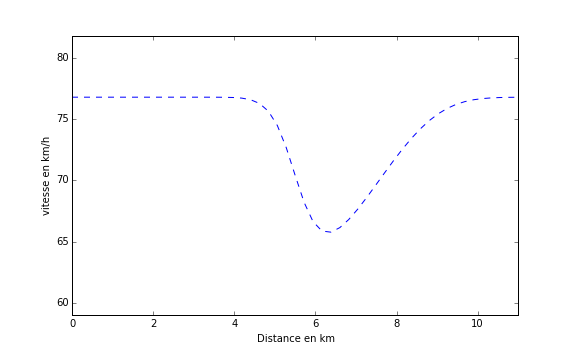
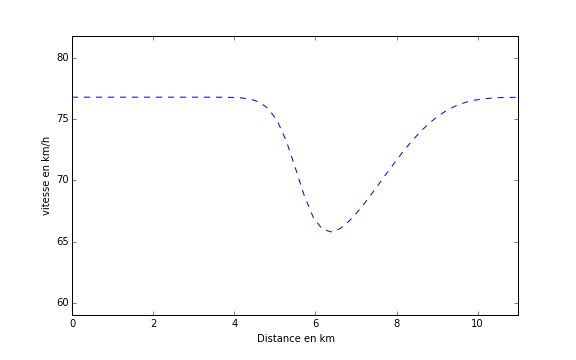
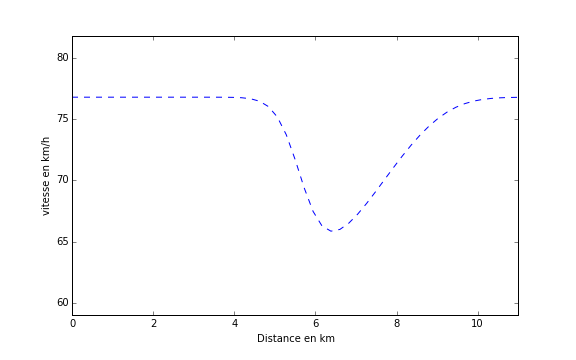
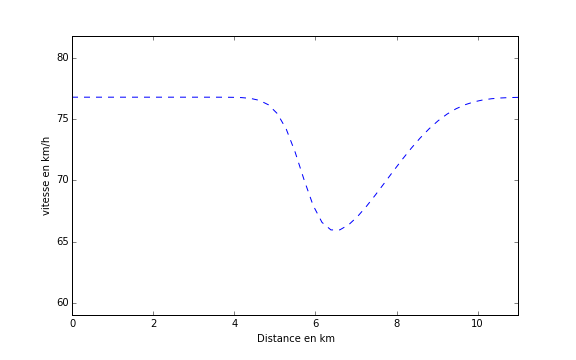
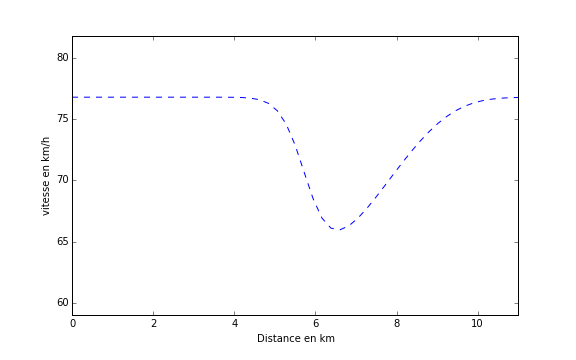
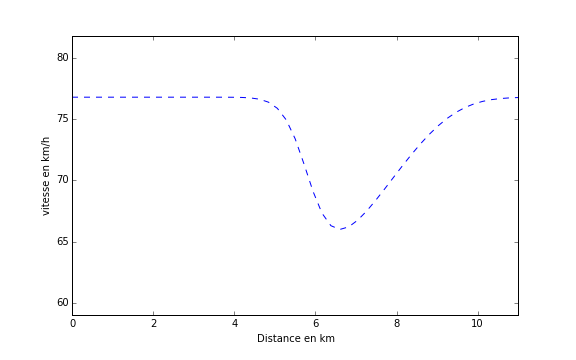
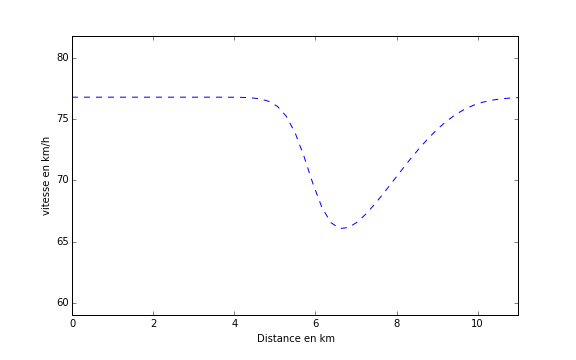
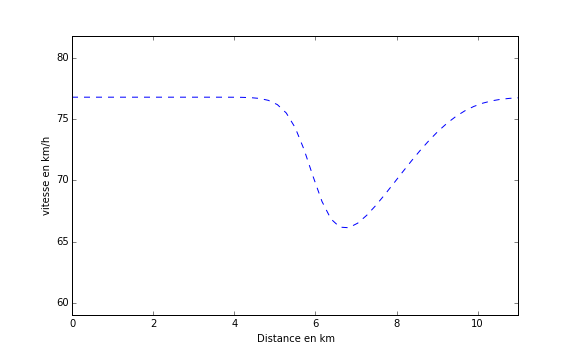
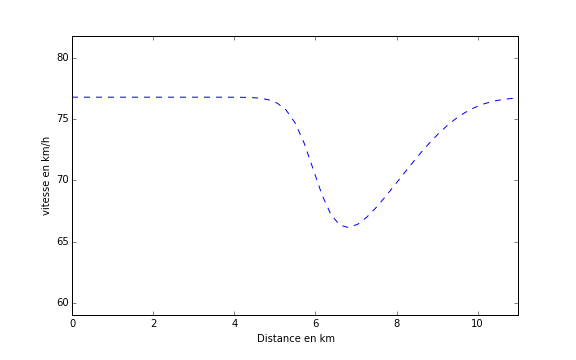
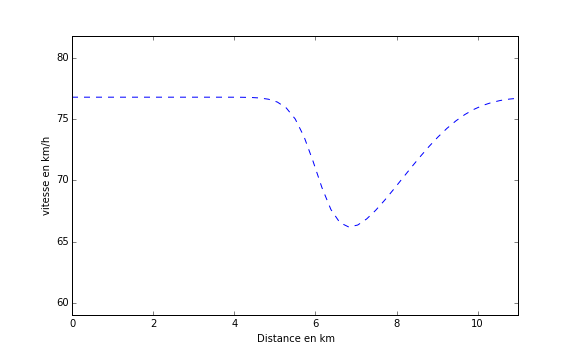
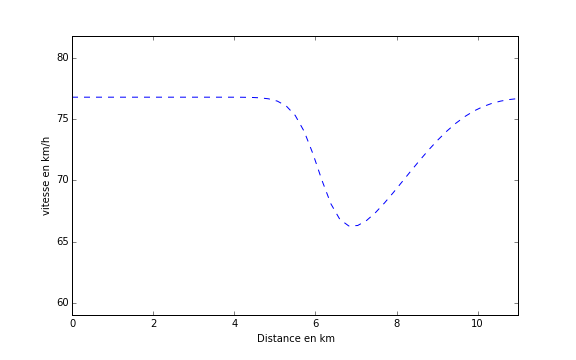
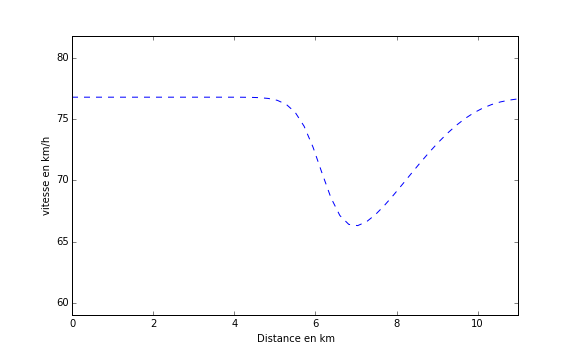
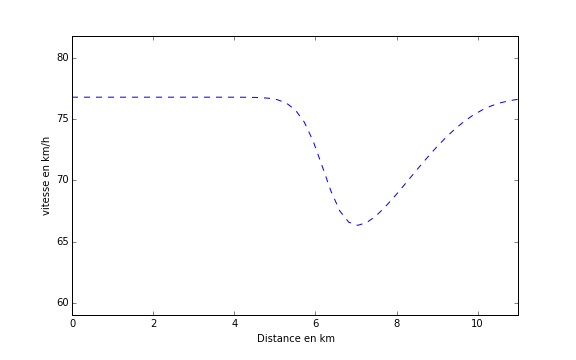
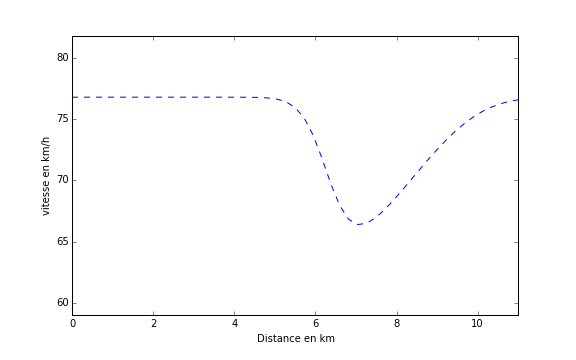
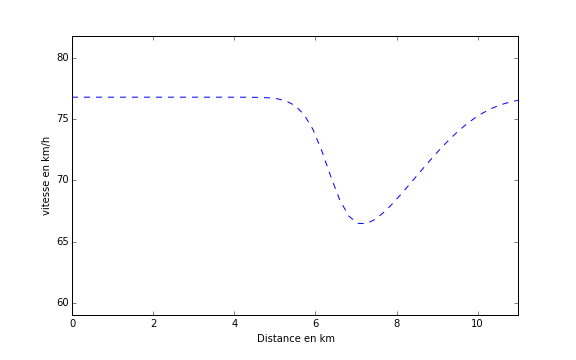
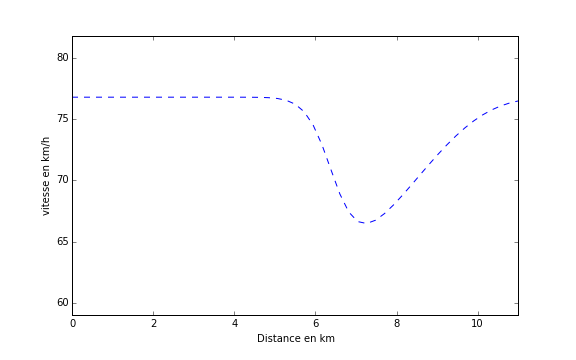
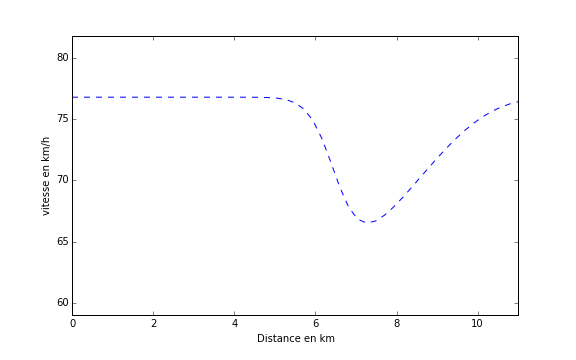
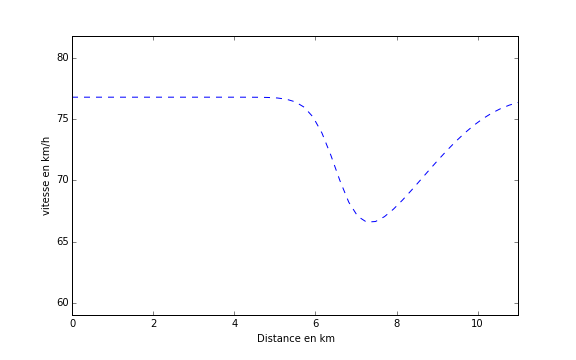
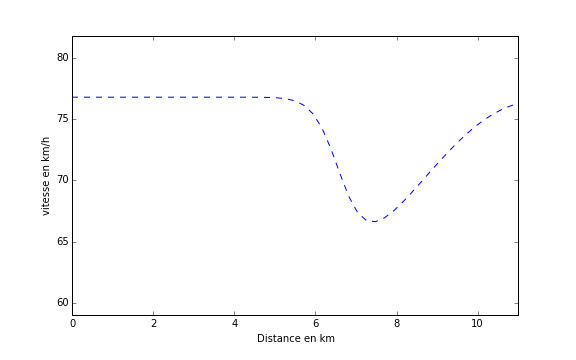
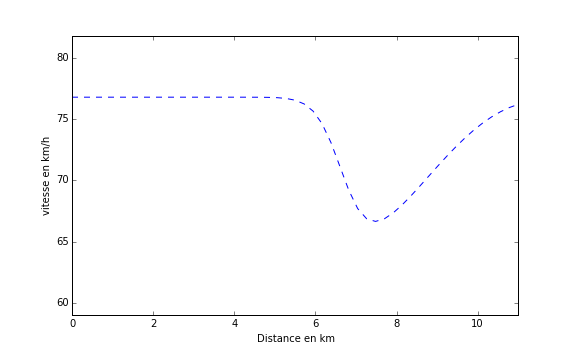
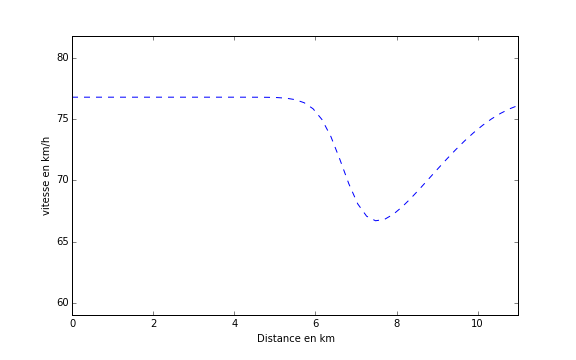
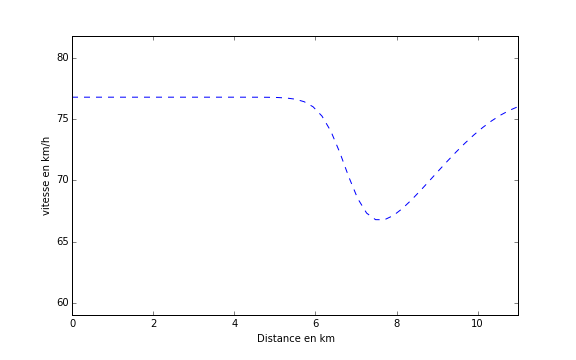
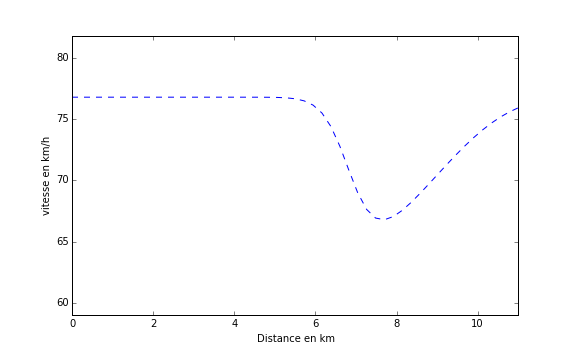
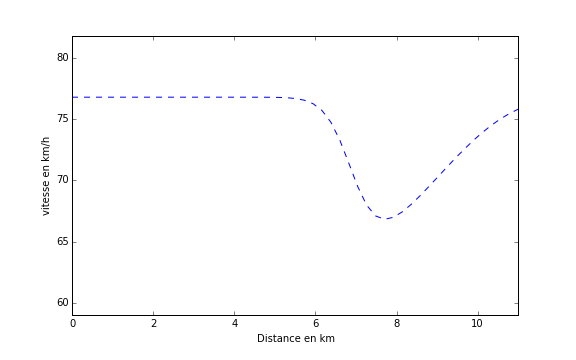
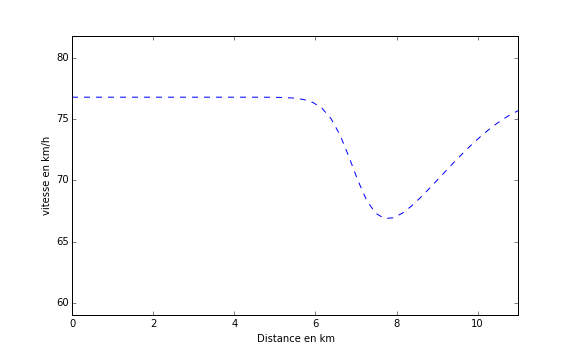
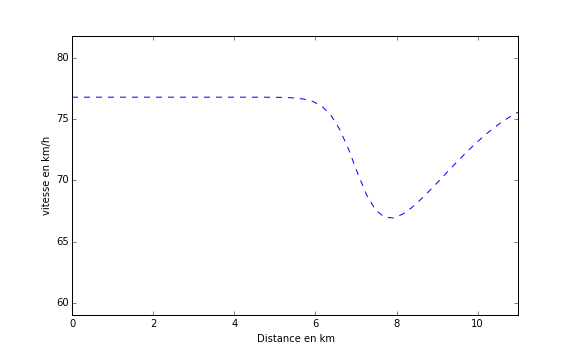
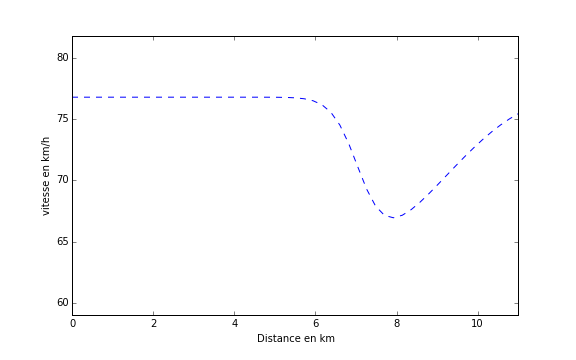
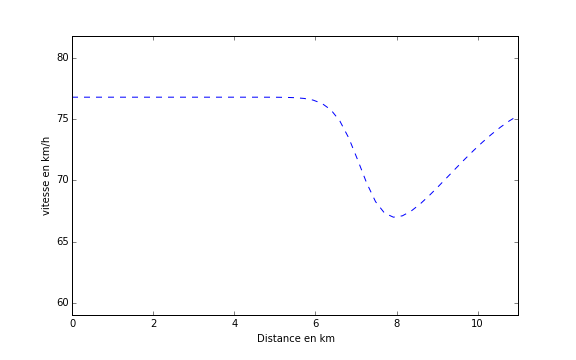
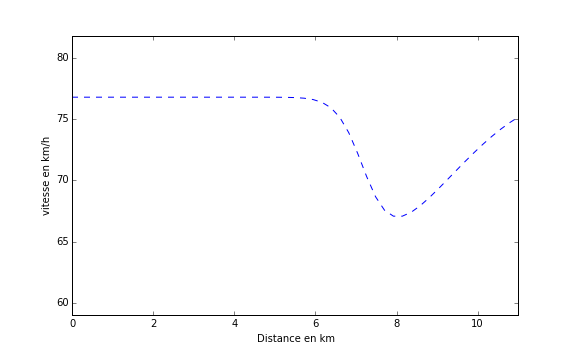
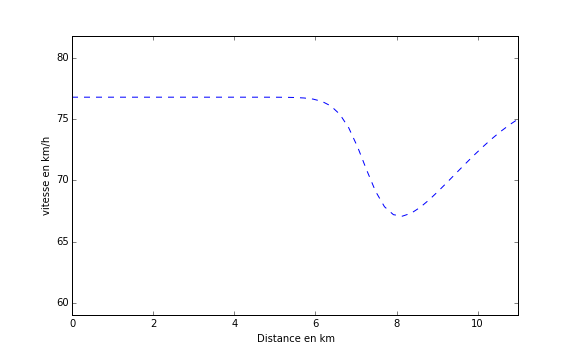
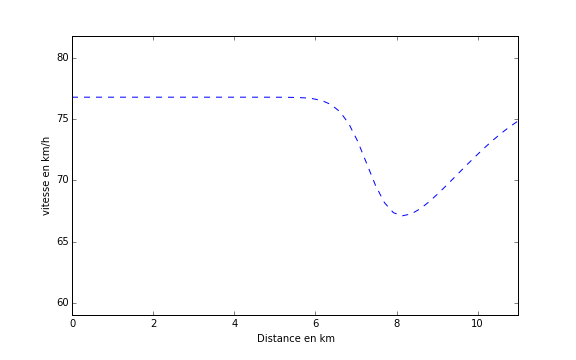
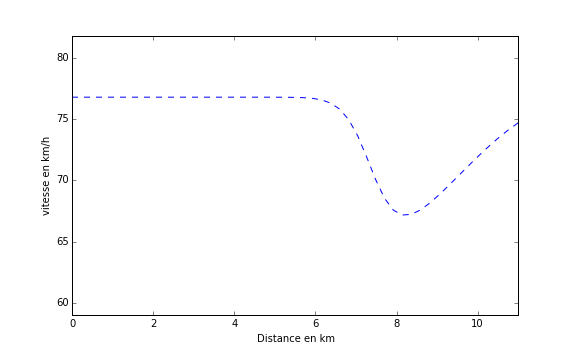
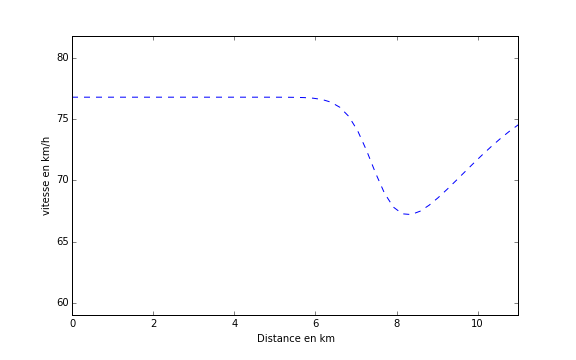
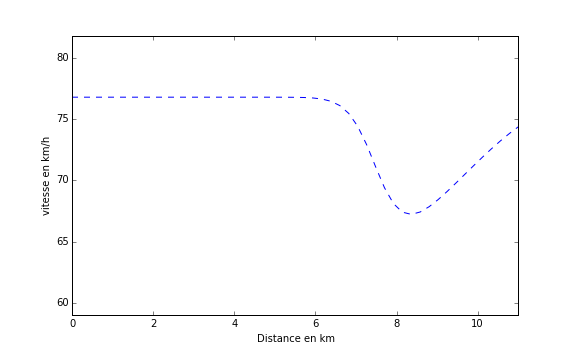
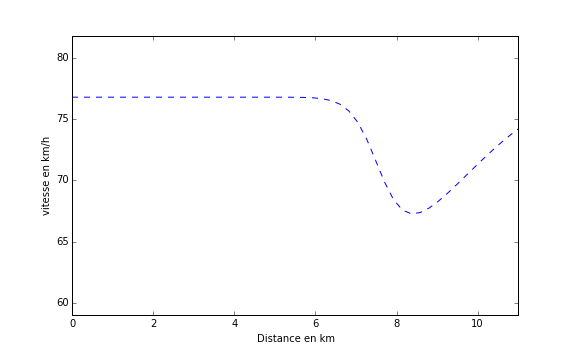
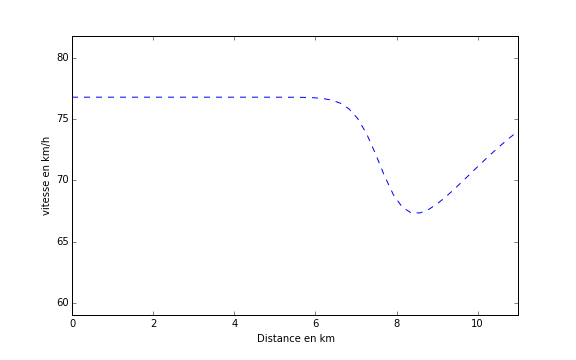
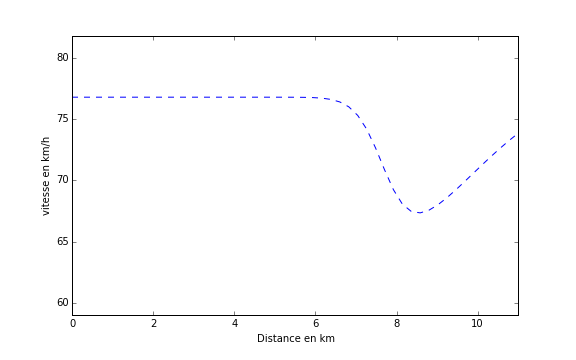
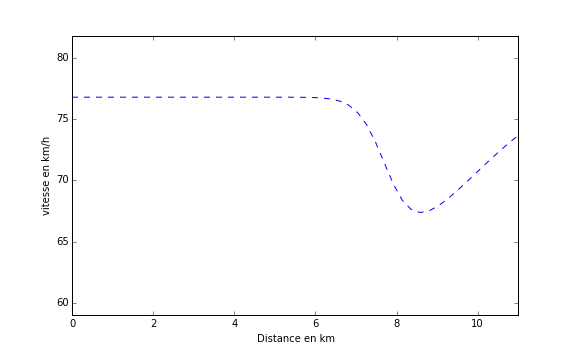
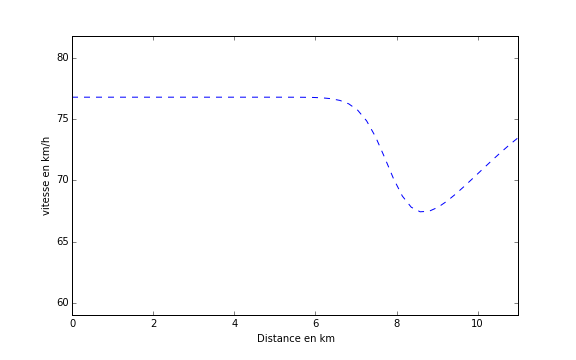
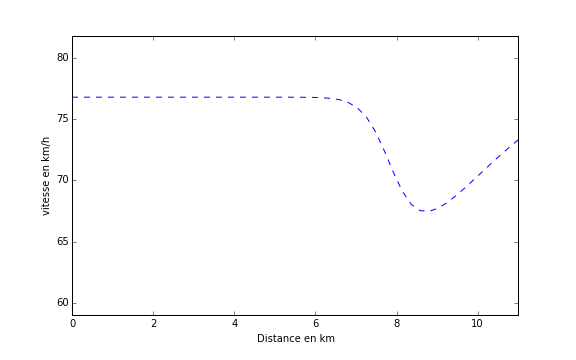
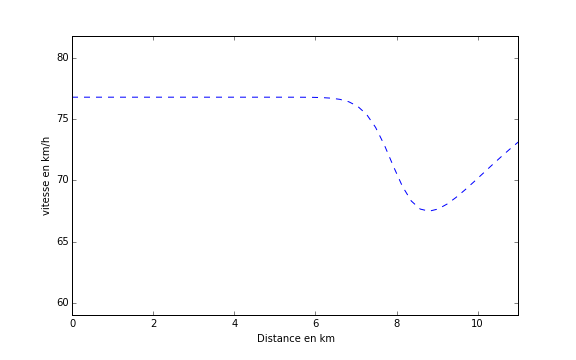
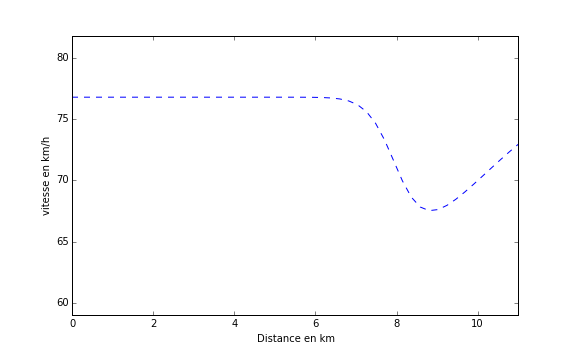
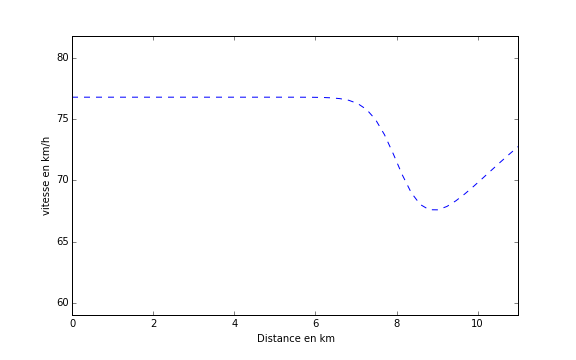
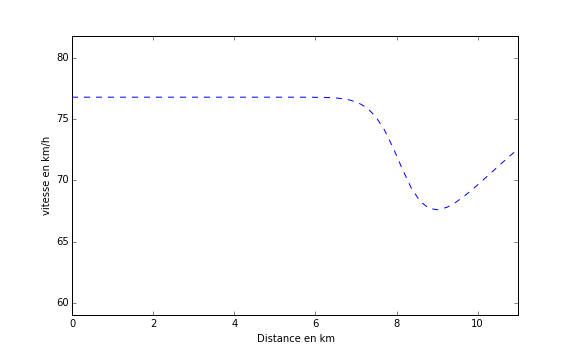
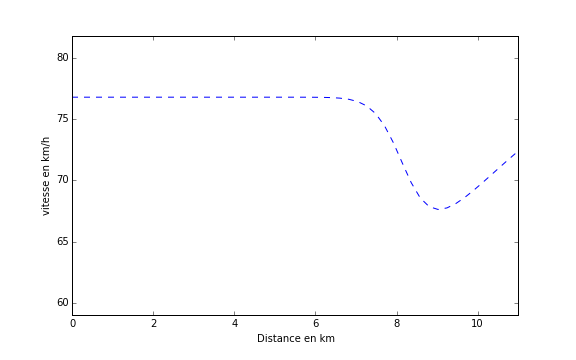

In [16]:
v,rho,vm = Traffic(50,10,80,6) 
visual(v,"Distance en km","vitesse en km/h")   

## 4.Conclusion



Cette partie du travail nous a permis de mieux comprendre la différence entre une solution analytique et une solution numérique. Dans le premier cas, que nous ayons fait $\frac{\partial F}{\partial \rho}\frac{\partial \rho}{\partial x}$ ou $\frac{\partial F}{\partial x}$, la règle de la "chain rule" nous dit qu'elles sont équivalentes l'une de l'autre. Dans le second cas, nous avons remarqué une différence notable entre les deux, quand nous faisons $\frac{\partial F}{\partial \rho}\frac{\partial \rho}{\partial x}$ nous n'obtenons pas la même discrétisation et de ce fait, la même solution que quand nous faisons $\frac{\partial F}{\partial x}$. 

Il faut donc faire attention à cette différence pour voir quelle discrétisation correspond le mieux à la résolution du problème.

Nous voyons aussi que pour mieux comprendre un phénomène, il faut comprendre tant mathématiquement que physiquement ce qu'il se passe. Ici, nous pouvions voir que la physique permettait de comprendre la dissipation et l'étalement du pic de densité de manière plus concrète même si les mathématiques nous le prouvaient de par les équations.